In [3]:
import os
import shutil



direc = 'KICs_test'
KIC = 'KICTEST'
for filename in os.listdir(direc):
    print(filename)
    KIC = stripstuff

if not os.path.exists(direc + '/' + KIC): #searching for, and making the directories if they don't exist
    os.makedirs(direc + '/' + KIC)
#os.rename("path/to/current/file.foo", "path/to/new/destination/for/file.foo")
#shutil.move("path/to/current/file.foo", "path/to/new/destination/for/file.foo")

kplr001028018-2011073133259_llc.fits.flare
kplr001028018-2011177032512_llc.fits.fake
kplr001028018-2011177032512_llc.fits.flare
kplr001028018-2011271113734_llc.fits.fake
kplr001028018-2011271113734_llc.fits.flare
kplr001028018-2012004120508_llc.fits.fake
kplr001028018-2012004120508_llc.fits.flare
kplr001028018-2012088054726_llc.fits.fake
kplr001028018-2012088054726_llc.fits.flare
kplr001028018-2012179063303_llc.fits.fake
kplr001028018-2012179063303_llc.fits.flare
kplr001028018-2012277125453_llc.fits.fake
kplr001028018-2012277125453_llc.fits.flare
kplr001028018-2013011073258_llc.fits.fake
kplr001028018-2013011073258_llc.fits.flare
kplr001028018-2013098041711_llc.fits.fake
kplr001028018-2013098041711_llc.fits.flare
kplr001028018-2013131215648_llc.fits.fake
kplr001028018-2013131215648_llc.fits.flare
kplr001570924-2009166043257_llc.fits.fake
kplr001570924-2009166043257_llc.fits.flare
kplr001570924-2009259160929_llc.fits.fake
kplr001570924-2009350155506_llc.fits.fake
kplr001570924-200935015

In [100]:
import sys
import os
from glob import glob
from decimal import Decimal
from pylab import *
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 14,10
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 25
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
BJD_2008 = 2454466.500000
EPOINT = 0
bic_threshold = 4
#np.seterr(invalid='ignore')
#cmap = plt.cm.Spectral # color scheme -- visible color spectrum, starting with red as the earliest
cmap = plt.cm.coolwarm
color = plt.cm.ScalarMappable(cmap=cmap)
day_range = [0,400,800,1200,1600]
color.set_array(day_range)

names=("t_start", "t_stop", "t_peak", "amplitude", "FWHM", "duration", "t_peak_aflare1",
       "t_FWHM_aflare1", "amplitude_aflare1", "flare_chisq", "KS_d_model", "KS_p_model",
       "KS_d_cont", "KS_p_cont", "Equiv_Dur", "ED68i", "ED90i")

In [105]:
try:
    file = 'KICs/targets.txt'
    targets = open(file, "r") # a file containing all the KICs we want to plot
except:
    print("\nERROR: Cannot open "+file+".")
    #sys.exit()

evfDir = 'energy_vs_frequency_plot'
evfsubDir = 'energy_vs_frequency_subtraction_plot'
mean_fit = 'time_vs_mean_difference'
mean_fit_grouped = 'time_vs_mean_difference_grouped'
tvfDir = 'time_vs_frequency_plot'
TVFfitData = 'TVF_fit_data'
EVFMfitData = 'EVFM_fit_data'


if not os.path.exists(evfDir): #searching for, and making the directories if they don't exist
    os.makedirs(evfDir)
if not os.path.exists(evfsubDir):
    os.makedirs(evfsubDir)
if not os.path.exists(mean_fit):
    os.makedirs(mean_fit)
if not os.path.exists(mean_fit_grouped):
    os.makedirs(mean_fit_grouped)
if not os.path.exists(tvfDir):
    os.makedirs(tvfDir)
if not os.path.exists(TVFfitData):
    os.makedirs(TVFfitData)
if not os.path.exists(EVFMfitData):
    os.makedirs(EVFMfitData)


SHOWE = False #check_args("-se")
ERRORE = False #check_args("-ee")
WHOLE = False #check_args("-w")
SHOWES = False #check_args("-ses")
SHOWM = True #check_args("-sm")
ERRORM = True #check_args("-em")
SHOWT = True #check_args("-st")
ERRORT = True #check_args("-et")
SAVEPLOT = True #check_args("-saveplot")
SAVETXT = True #check_args("-savefit")

print("Input a .txt file containing the names of the KIC's you want to evaluate. After that, include:\n"+
"For the Energy_vs_frequency analysis:\n'-se': show plots\n'-w' : show the whole plot, including data below ok68 cutoff\n'-ee': include error bars in the plots\n\n"+
"For the Energy_vs_frequency subtraction step:\n'-ses': show plots\n\n"+
"For the Time_vs_frequency mean-fit analysis:\n'-sm': show plots\n'-em': show error on the plots\n\n"+
"For the Time_vs_fruency analysis:\n'-st': show plots\n\n"+
"Use '-saveplot' to save all of the plots\n"+
"Use '-savefit' to save the fit data\n")

Input a .txt file containing the names of the KIC's you want to evaluate. After that, include:
For the Energy_vs_frequency analysis:
'-se': show plots
'-w' : show the whole plot, including data below ok68 cutoff
'-ee': include error bars in the plots

For the Energy_vs_frequency subtraction step:
'-ses': show plots

For the Time_vs_frequency mean-fit analysis:
'-sm': show plots
'-em': show error on the plots

For the Time_vs_fruency analysis:
'-st': show plots

Use '-saveplot' to save all of the plots
Use '-savefit' to save the fit data



# A collection of functions

In [128]:
'''if (len(sys.argv)==1):
    print("ERROR: NO TARGET FILE INCLUDED")
    sys.exit()'''

'''def check_args(key):
    for x in range(len(sys.argv)-2):
        if sys.argv[x+2]==key:
            return True
    return False'''



def getSize(file):
    '''Returning the number of KICs in a targettext file.

    Parameters
    ----------
    file : string
        The path to the file containing the list of KICs.


    Returns
    -------
    getsize.size : integer
        The number of KICs in the file.
    '''
    temp = pd.read_table(file, names=['kic'])
    getsize = temp['kic'].values
    return getsize.size



def calcChiSq(data, fit, errList):
    '''Caclulate the Chi-Squared value between a fit and the raw data

    Parameters
    ----------
    data : array
        An array of the flare frequency data.

    fit : array
        An array of the fit data

    errList : array
        An array of the error in each fit


    Returns
    -------
    chiSq : float
        the calculated Chi-Square Value
    '''
    chiSq = np.sum(((data - fit) / errList)**2.0)/np.size(data)
    chiSq = np.sum(((data - fit))**2.0)/np.size(data)
    return chiSq



def calcError(data, multiple):
    '''Calculating the asymmetric error bar for each data point

    Parameters
    ----------
    data : array
        An array of the flare frequency data.

    multiple : integer
        The total duration (in days) of each quarter, so that we can get turn the data
        from a #/day unit to a total #, allowing for error bar calculation


    Returns
    -------
    errUp : float
        the upper error bar

    errDn : flaot
        the lower error bar
    '''
    data = data*multiple
    errDn = (np.abs(data * (1.-1./(9. * data)-1./(3.*np.sqrt(data)))**3.-data))/multiple
    errUp = (np.sqrt(data + 0.75) + 1.0)/multiple
    return errUp, errDn





def calcBic(size, degree, chiSq):
    '''Using the Bayesian Information Criterion calculation

    Parameters
    ----------
    size : integer
        The number of data points.
    degree: integer
        The degree of the polynomial fit.
    chiSq : float
        Chi-Squared value.


    Returns
    -------
    bic : float
        the Bayesian Information Criterion Value
    '''
    bic = size*np.log(chiSq) + ((degree+1) * np.log(size))
    #aic = size*np.log(chiSq) + ((degree+1) * 2)
    return bic #aic



def fitDegreeK(xaxis, yaxis, errList, degree, size, fit_linspace):
    '''Fitting a polynomial of degree K

    Parameters
    ----------
    xaxis,yaxis : arrays
        The x and y axis values that will be fit.

    errList : array
        The data's associted error bars.

    degree : integer
        The degree of the polynomial to be fit.

    size : integer
        The number of data points.


    Returns
    -------
    bic : float
        The Bayesian Information Criterion value.

    fit : array
        An array containing the best fit of degree k.

    parameters : array
        Coefficients for the fit.

    covariance : matrix (array)
        The covariance matric associated w/ the fit.

    chiSq : float
        The Chi-Squared value.
    '''

    if(degree == 0):
        parameters = [np.mean(yaxis)]
        covariance = np.array([[np.std(yaxis)**2,0],[0,0]])
    else:
        parameters, covariance = np.polyfit(xaxis, yaxis, degree, cov=True, full =False, w=(1/errList))

    fit = np.polyval(parameters, fit_linspace)
    fit_at_data = np.polyval(parameters, xaxis)
    chiSq = calcChiSq(yaxis, fit_at_data, errList)
    bic = calcBic(size, degree, chiSq)
    return bic, fit, parameters, covariance, chiSq




def updateArray(Fit_Data, targetIndex, KIC, size, group_size, degree, bestParameters, bestChiSquare, bestCov, bics):
    '''Updating an array that contain all of the relevant fit data

    Parameters
    ----------
    Fit_Data : array
        The array that will be updated.

    targetIndex : integer
        The index that keeps track of which KIC we're on.

    KIC : string
        The KIC who's data is getting sent to the array.

    size : integer
        Number of data points.

    degree : interger
        The degree of the fit.

    bestParameters : array
        The coefficients of the best fit polynomial.

    bestChiSquare : float
        The Chi-Square of the best fit.

    bestCov : array
        The covariance matrix of the best-fit, returned by polyfit.


    Returns
    -------
    Fit_Data : array
        The array being updated with the fit data, which will eventually be exported (written) to a file
    '''
    Fit_Data[targetIndex, 0] = KIC
    Fit_Data[targetIndex, 1] = size
    Fit_Data[targetIndex, 2] = group_size
    Fit_Data[targetIndex, 3] = degree
    Fit_Data[targetIndex, 4] = '{}'.format('%.5f'%bestChiSquare)
    length = len(bestParameters)

    for x in range(length):
        Fit_Data[targetIndex, (9-length+x)] = '{}'.format('%.15f'%bestParameters[x])
        Fit_Data[targetIndex, (13-length+x)] = '{}'.format('%.15f'%(np.sqrt(bestCov[x,x])))
    for x in range(4):
        Fit_Data[targetIndex, (13+x)] = '{}'.format('%.15f'%(bics[-(x+1)]))
          
    return Fit_Data





def compareFits(xaxis, yaxis, errList, fit_linspace):
    '''Comparing two fits, and determining which fit is the 'best' based on the Bayseian information criterion

    Parameters
    ----------
    xaxis,yaxis : arrays
        The x and y axis values that will be fit.

    errList : array
        The error associated with each point

    Returns
    -------
    bestFit : array
        The data from the best fit polynomial.

    bestParameters : array
        The coefficients of polynomial being used to fit the data.

    bestCovariance : array
        A covariance matrix of the bestfit, returned by polyfit

    bestChiSquare : float
        The Chi-Square of the best fit

    bestFitDegree : integer
        The degree of the polynomial being used to fit the data.

    size: integer
        The number of data points in the fit
    '''
    bics = np.zeros(4)
    size = np.size(xaxis)
    bestFitDegree = 0
    bic1, bestFit, bestParameters, bestCovariance, bestChiSquare = fitDegreeK(xaxis, yaxis, errList, bestFitDegree, size, fit_linspace)
    bics[0] = bic1
    degree = 1

    while(degree<4):
        try:
            bic2, fit, parameters, covariance, chiSquare = fitDegreeK(xaxis, yaxis, errList, degree, size, fit_linspace)
            bics[degree] = bic2
        except:
            print("Couldn't fit the BIC eval polynomial")
            bics[degree] = 99
            break
        if ((bic1 - bic2) >=bic_threshold):
            bic1, bestFit, bestParameters, bestCovariance, bestChiSquare = bic2, fit, parameters, covariance, chiSquare
            bestFitDegree = degree
        elif((bic1 - bic2) <= 0):
            break
        else:
            bic1 = bic2
        degree+=1
        #else:
        #    break
    return bestFit, bestParameters, bestCovariance, bestChiSquare, bestFitDegree, size, bics


def get_label(bestParameters, bestFitDegree, group_size):
    label = "BIC-fit\nP_0: "+ str('%.2E' % Decimal(bestParameters[-1]))   
    for x in range(bestFitDegree):
        label = label + "\nP_"+str(x+1)+": "+str('%.2E' % Decimal(bestParameters[-(x+2)]))
    label = label + "\ngroup size: " + str(group_size)
    return label

base = 2.5

def calc_error_during_subtraction(data, data_err, fit_coeff, coeff_err, toteDuration):
    a = fit_coeff[0]
    b = fit_coeff[1]
    c = fit_coeff[2]
    da = coeff_err[0]
    db = coeff_err[1]
    dc = coeff_err[2]
    df_squared = (a* data * base**(-b*data)*db)**2 + (base**(-b*data)*da)**2 + dc**2
    difference_err = np.sqrt(df_squared + data_err**2) 
    return difference_err


def exp_decay(x, a, b, c):
    return a*base**(-b*x)+c



def plot_time_vs_frequency(KIC, files, fileCount, TVF_Fit_Data, fixedEnergy, targetIndex, **kwargs):
    plt.figure()
    plt.title(str(KIC))
    plt.ylabel(r"$\nu$")
    plt.xlabel("$BJD_{TDB}-2454832$")
    plt.yscale('log')

    xaxis = np.array([])
    yaxis = np.array([])
    errListUp = np.array([])
    errListDn = np.array([])

    
    
    #loop over each .flare file
    for x in range(fileCount):

        toteDuration = pd.read_table(files[x], skiprows=5, nrows=1, header=None, delim_whitespace=True, usecols=(7,)).iloc[0].values[0] #getting the total duration of each file
        df = pd.read_table(files[x], comment="#", delimiter=",", names=names)
        energy = np.array(df['Equiv_Dur']) #This is the energy column of the flare data
        positive = np.where(energy > 0)
        energy_p = energy[positive]
        sort = np.argsort(energy_p) #get inp.wherendices that would sort the energy array
        ffdXEnergy = (np.log10(energy_p) + EPOINT)[sort][::-1] #log the reverse of sorted energy
        ffdXEnergy = ffdXEnergy[np.isfinite(ffdXEnergy)]
        ffdYFrequency = (np.arange(1, len(ffdXEnergy)+1, 1))/toteDuration #get evenly spaced intervals, divide by totedur to get flares/day

        if(np.amax(ffdXEnergy) >= fixedEnergy >= np.amin(ffdXEnergy)): #checking that the energy constant isn't out of bound,otherwise, interpolate doesn't work

            meanStart = np.sum(df['t_start'])/len(df['t_start']) #finding the mean time for a file
            ffdYAtEnergy = np.interp(fixedEnergy, ffdXEnergy[::-1], ffdYFrequency[::-1])#interpolating the ffd_y
            xaxis = np.append(xaxis, meanStart) #making lists so we can fit a line later
            yaxis = np.append(yaxis, ffdYAtEnergy)

            errUp, errDn = calcError(ffdYAtEnergy, toteDuration)#dealing w/ error
            errListUp = np.append(errListUp, errUp)
            errListDn = np.append(errListDn, errDn)

    fit_linspace = np.linspace(min(xaxis), max(xaxis), num=100)
    bestFit, bestParameters, bestCovariance, bestChiSquare, bestFitDegree, size, bics = compareFits(xaxis, yaxis, errListUp, fit_linspace)
    TVF_Fit_Data = updateArray(TVF_Fit_Data, targetIndex, KIC, size, 1, bestFitDegree, bestParameters, bestChiSquare, bestCovariance, bics)
        
    plt.scatter(xaxis, yaxis, c=xaxis, cmap=cmap, lw=6)  
    label = get_label(bestParameters, bestFitDegree, 1)
    plt.plot(fit_linspace, bestFit, 'black', lw=4, label=label)
    if(kwargs['errort']==True):
        plt.errorbar(xaxis, yaxis, yerr = [errListDn,errListUp], c='black', fmt='o', markersize=0, elinewidth=.8, capsize=6)#plotting error
    plt.legend(loc="upper right")  
      
    if(kwargs['save']==True):
        plt.savefig('time_vs_frequency_plot/'+str(KIC)+'_vs_time_E='+str(fixedEnergy)+'.png')
    if(kwargs['showt']==True):
        plt.show()
    plt.close()





def plot_energy_vs_frequency(KIC, files, fileCount, **kwargs):
    plt.figure()
    plt.title(str(KIC))
    plt.ylabel(r"$\nu$")
    plt.xlabel("Log Equivalent Duration")
    plt.yscale('log')

    errListUp = np.array([])
    errListDn = np.array([])
    totalEVFFitX = np.array([])
    totalEVFFitY = np.array([])
    quarterlyEVFX = []
    quarterlyEVFY = []
    time = np.array([])
    
    for x in range(fileCount):
        toteDuration = pd.read_table(files[x], skiprows=5, nrows=1, header=None, delim_whitespace=True, usecols=(7,)).iloc[0].values[0] #getting the total duration of each file
        df = pd.read_table(files[x], comment="#", delimiter=",", names=names)
        energy = np.array(df['Equiv_Dur']) #This is the energy column of the flare data
        positive = np.where(energy > 0)
        energy_p = energy[positive]
        sort = np.argsort(energy_p) #get indices that would sort the energy array
        ffdXEnergy = np.log10((energy_p + EPOINT)[sort][::-1])#log the reverse of sorted energy
        ffdYFrequency = (np.arange(1, len(ffdXEnergy)+1, 1))/toteDuration #get evenly spaced intervals, divide by totedur to get flares/day

        ok68 = (ffdXEnergy >= np.log10(np.median(df['ED68i'])) + EPOINT)

        if (any(ok68)):#taking care of the mean-fit data
            quarterlyEVFX.append(ffdXEnergy[ok68])
            quarterlyEVFY.append(ffdYFrequency[ok68])
            time = np.append(time, np.sum(df['t_start'])/len(df['t_start'])) #finding the mean time for a file

        if(kwargs['whole']==True):  #plotting all data
            ok68 = np.isfinite(ffdXEnergy)
            
        totalEVFFitX = np.append(totalEVFFitX, ffdXEnergy[ok68])
        totalEVFFitY = np.append(totalEVFFitY, ffdYFrequency[ok68])

        plt.plot(ffdXEnergy[ok68], ffdYFrequency[ok68], lw = 1, c = cmap(x/float(len(files))))
        errUp, errDn = calcError(ffdYFrequency[ok68], toteDuration)
        errListUp = np.append(errListUp, errUp)  #errup>>errDn


        if(kwargs['errore']==True):
            plt.errorbar(ffdXEnergy[ok68], ffdYFrequency[ok68], yerr = [errDn, errUp], c = 'black', elinewidth=.3, fmt='o', markersize = .55)

    sort = np.argsort(totalEVFFitX)
    try:
        offset = min(totalEVFFitX) #starting the data at x=0 to reduce error in the the fit
        popt, pcov = curve_fit(exp_decay, totalEVFFitX[sort]-offset, totalEVFFitY[sort], p0=(.1, .1, .1), sigma = errListUp)
        perr = np.sqrt(np.diag(pcov))

        exp_fit = exp_decay(totalEVFFitX[sort]-offset, *popt)
        positive = np.where(exp_fit > min(totalEVFFitY))
        plt.plot(totalEVFFitX[sort][positive], exp_fit[positive], c='black', lw=4, label="Best-Fit")
        plt.legend(loc='upper right')

        if(kwargs['save']==True):
            plt.savefig('energy_vs_frequency_plot/'+ str(KIC) + '.png')
        if(kwargs['showe']==True):
            cbar = plt.colorbar(color, ticks=day_range)
            cbar.set_label('$BJD_{TDB}-2454832$', rotation=270)
            plt.show()
        plt.close()
        success = True
        
    except:
        print("Couldn't fit an exp_decay to " + KIC + ". Skipping further evaluation, moving on to the next KIC")
        success = False
        popt = perr = 0

    return quarterlyEVFX, quarterlyEVFY, popt, perr, toteDuration, time,offset, success





def plot_energy_vs_frequency_subtraction(KIC, quarterlyEVFX, quarterlyEVFY, popt,perr,offset, toteDuration, **kwargs):
    meanValues = np.array([])
    mean_errors = np.array([])
    plt.figure()
    plt.title(str(KIC))
    plt.ylabel(r'$\nu$ - $\bar \nu$')
    plt.xlabel("Log Equivalent Duration")

    for q in range(len(quarterlyEVFX)):
        fit = exp_decay(quarterlyEVFX[q]-offset, *popt)
        errUp, errDn = calcError(quarterlyEVFY[q], toteDuration)
        difference_err = calc_error_during_subtraction(quarterlyEVFX[q]-offset, errUp, popt, perr ,toteDuration)   
        difference = quarterlyEVFY[q]-fit
        plt.plot(quarterlyEVFX[q], difference, c = cmap(q/float(len(quarterlyEVFX))))
        #plt.errorbar(quarterlyEVFX[q], difference, yerr = [difference_err, difference_err], c = 'black', elinewidth=.6, fmt='o', markersize = 2, capsize=2)
        mean = np.mean(difference)
        mean_err = np.sqrt(np.sum(errUp**2))/np.size(errUp)
        meanValues = np.append(meanValues, mean)
        mean_errors = np.append(mean_errors, mean_err)
    
    if(kwargs['save']==True):
        plt.savefig('energy_vs_frequency_subtraction_plot/'+ str(KIC) + '.png')
    if(kwargs['showes']==True):
        cbar = plt.colorbar(color, ticks=day_range)
        cbar.set_label('$BJD_{TDB}-2454832$', rotation=270)
        plt.show()
    plt.close()
    return meanValues, mean_errors





def plot_time_vs_mean_frequency(KIC, time, meanValues, mean_errors, EVF_Mean_Fit_Data, targetIndex, **kwargs):
        fit_linspace = np.linspace(min(time), max(time), num=100)
        bestFit, bestParameters, bestCovariance, bestChiSquare, bestFitDegree, size, bics = compareFits(time, meanValues, mean_errors, fit_linspace)
        plt.figure()
        plt.title(str(KIC))
        plt.ylabel(r'$\overline{\nu - \bar \nu}$')
        plt.xlabel("$BJD_{TDB}-2454832$")
        
        label = get_label(bestParameters, bestFitDegree, 1)
        plt.scatter(time, meanValues, c=time, cmap=cmap, lw=6)  
        plt.plot(fit_linspace, bestFit, 'black', lw=4, label=label)
        if(kwargs['errorm']==True):
            plt.errorbar(time, meanValues, yerr = mean_errors, c='black', fmt='o', markersize=0, elinewidth=.8, capsize=6)
        plt.legend(loc='upper right')

        EVF_Mean_Fit_Data = updateArray(EVF_Mean_Fit_Data, targetIndex, KIC, size,1, bestFitDegree, bestParameters, bestChiSquare, bestCovariance, bics)
      
        if(kwargs['save']==True):
            plt.savefig('time_vs_mean_difference/'+ str(KIC) + '.png')
        if(kwargs['showm']==True):
            plt.show()
        plt.close()


        
def plot_time_vs_mean_frequency_grouped(KIC, time, meanValues, mean_errors,  group_size, EVF_Mean_Fit_Data, targetIndex,**kwargs):
    grouped_time = np.zeros([math.ceil(len(time)/group_size)])
    grouped_mean_vals = np.zeros([math.ceil(len(time)/group_size)])
    grouped_mean_errs = np.zeros([math.ceil(len(time)/group_size)])
    index = 0
    iterations = 0
    for x in range(len(time)):
        grouped_time[index] += time[x]
        grouped_mean_vals[index] += meanValues[x]
        grouped_mean_errs[index] += mean_errors[x]**2
        iterations += 1
        if((iterations == group_size) or (x == (len(time)-1))):
            grouped_time[index] = grouped_time[index]/iterations
            grouped_mean_vals[index] = grouped_mean_vals[index]/iterations
            grouped_mean_errs[index] = np.sqrt(grouped_mean_errs[index])
            iterations = 0
            index += 1
    
    fit_linspace = np.linspace(min(grouped_time), max(grouped_time), num=100)
    bestFit, bestParameters, bestCovariance, bestChiSquare, bestFitDegree, size, bics = compareFits(grouped_time, grouped_mean_vals, grouped_mean_errs, fit_linspace)
    plt.figure()
    plt.title(str(KIC))
    plt.ylabel(r'$\overline{\nu - \bar \nu}$')
    plt.xlabel("$BJD_{TDB}-2454832$")
    
    label = get_label(bestParameters, bestFitDegree, group_size)
    plt.scatter(grouped_time, grouped_mean_vals, c=grouped_time, cmap=cmap, lw=6) 
    plt.plot(fit_linspace, bestFit, 'black', lw=4, label=label)
    if(kwargs['errorm']==True):
        plt.errorbar(grouped_time, grouped_mean_vals, yerr = grouped_mean_errs, c='black', fmt='o', markersize=0, elinewidth=.8, capsize=6)
    plt.legend(loc='upper right')

    EVF_Mean_Fit_Data = updateArray(EVF_Mean_Fit_Data, targetIndex, KIC, size, group_size, bestFitDegree, bestParameters, bestChiSquare, bestCovariance, bics)

    if(kwargs['save']==True):
        plt.savefig('time_vs_mean_difference_grouped/'+ str(KIC) + '_GS_' + str(group_size) + '.png')
    if(kwargs['showm']==True):
        plt.show()
    plt.close()

# Plotting energy_vs_frequency for each KIC and time_vs_energy for each KIC/energy combination

-82.04686294177958
-80.218893685881


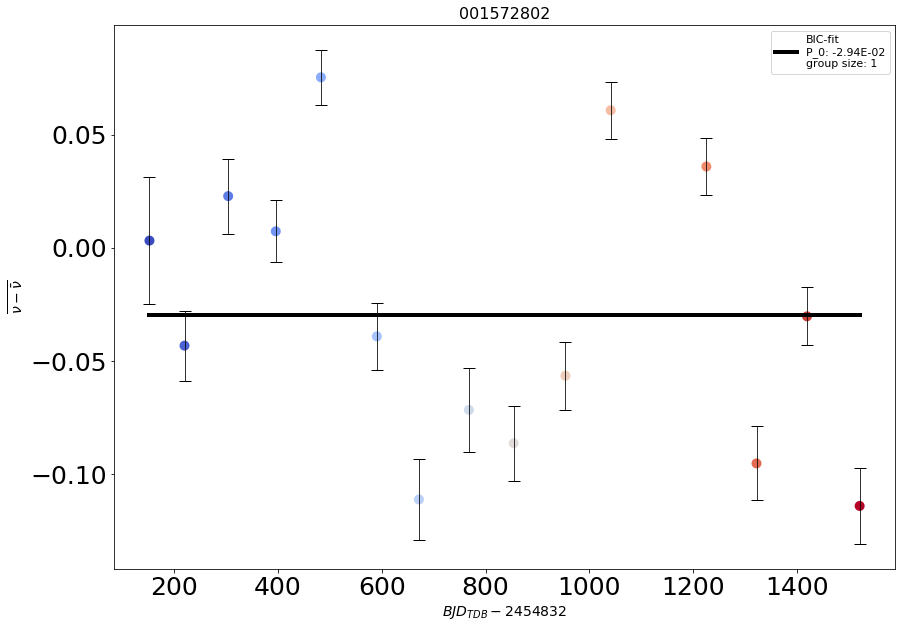

-44.38468960476664
-43.79308463733965


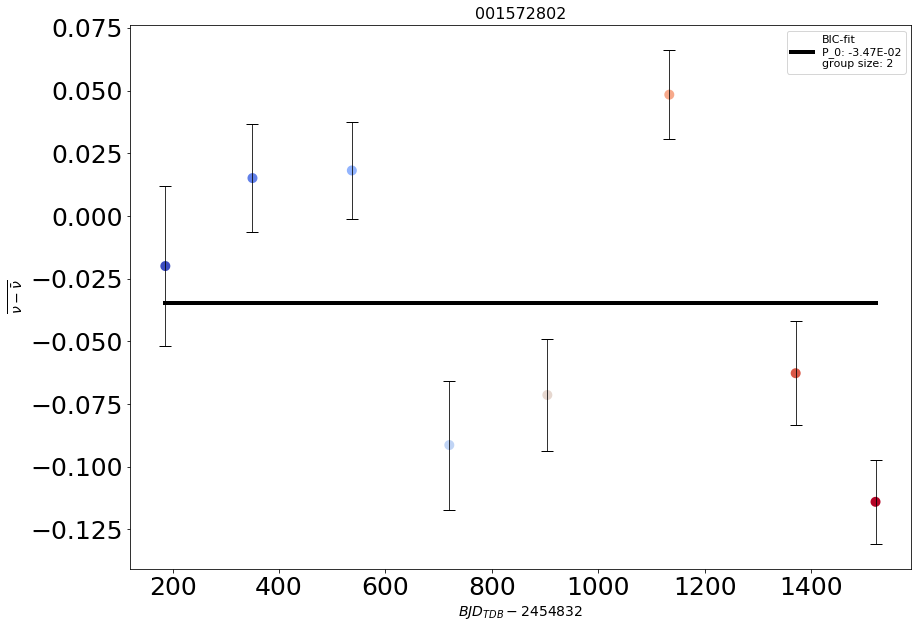

-29.21798833874837
-28.581214476021298


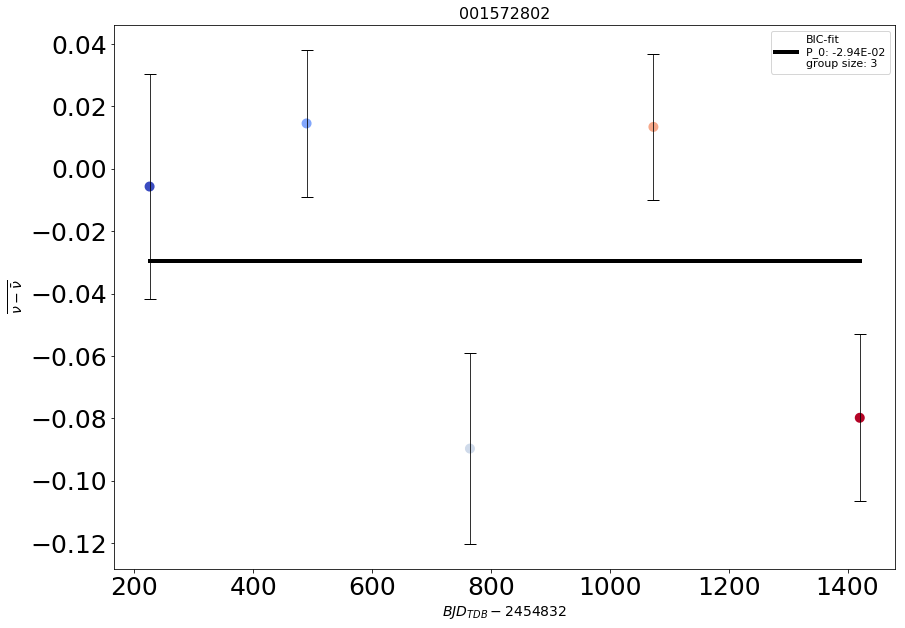

Couldn't fit an exp_decay to 001721614. Skipping further evaluation, moving on to the next KIC
-104.82829509053745
-110.29870743737322
-108.91411624333392


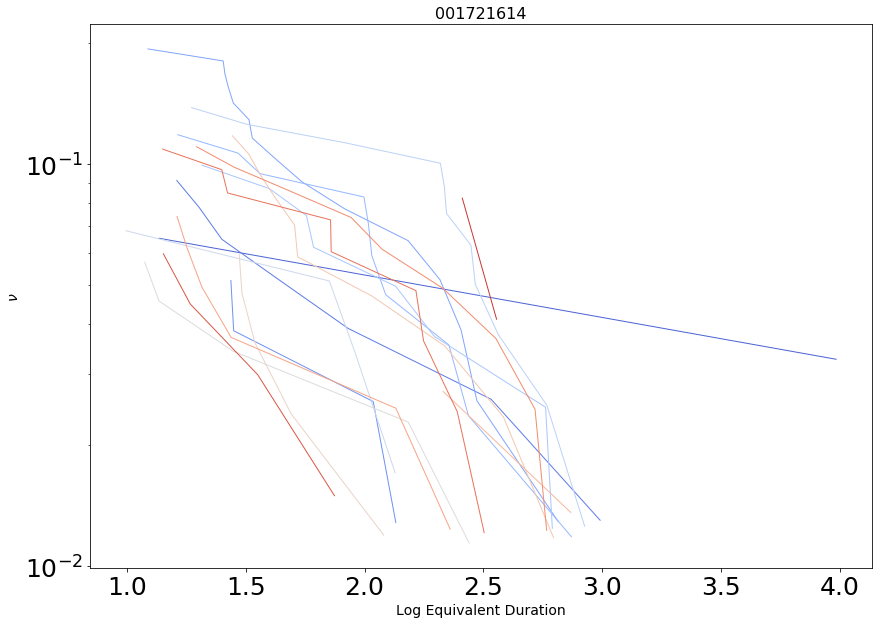

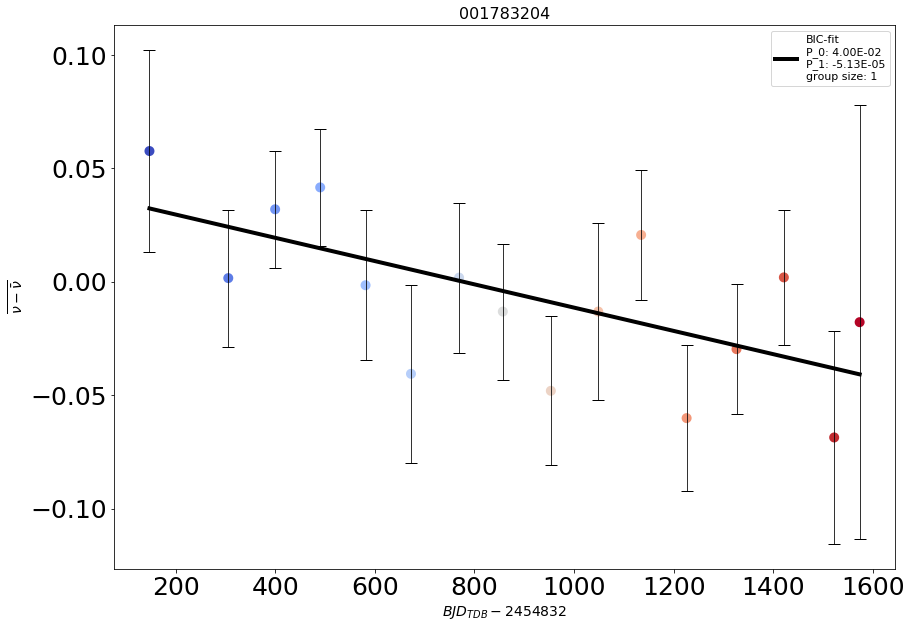

-56.146379252464435
-62.366417689415485
-60.17619225182675


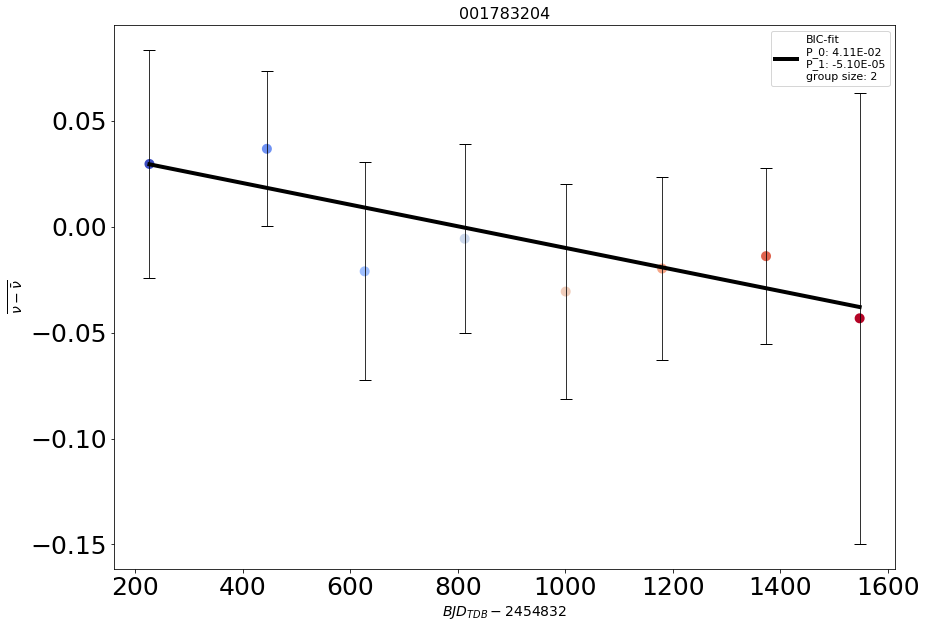

-45.07036415152757
-50.3388080471384
-58.71880983119409
Couldn't fit the BIC eval polynomial


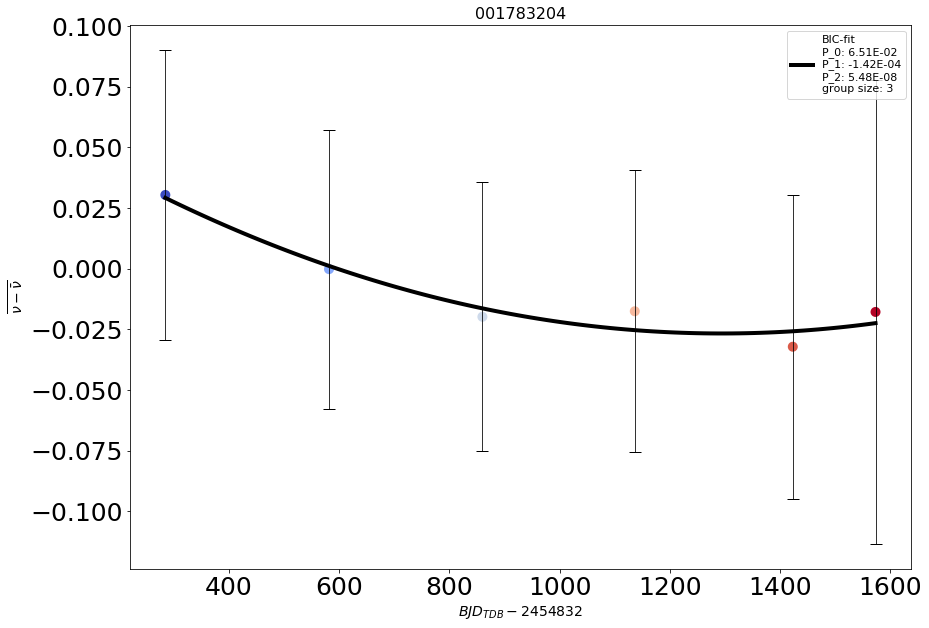

-84.04348933004522
-81.23745912542229


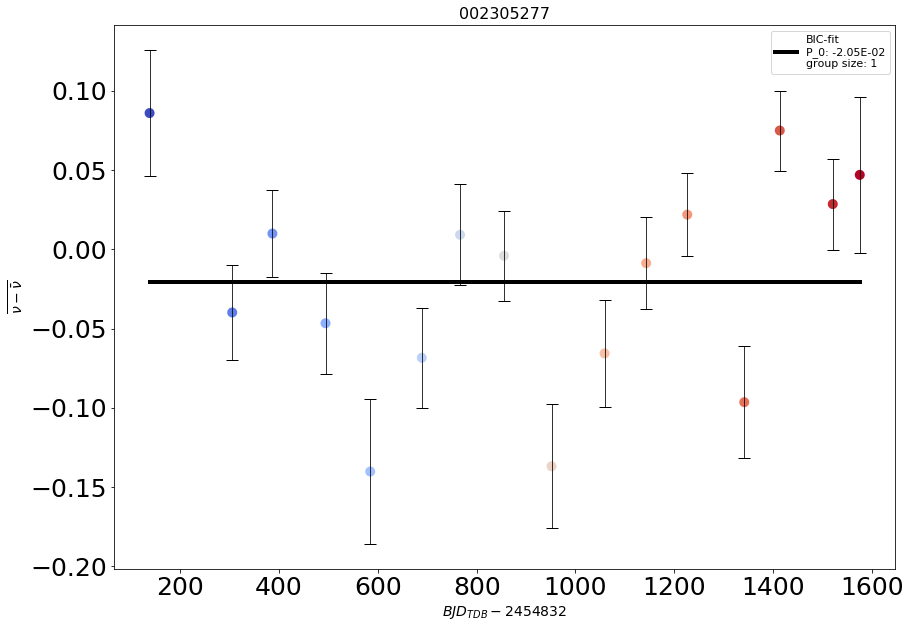

-45.774536751415084
-43.881603056196916


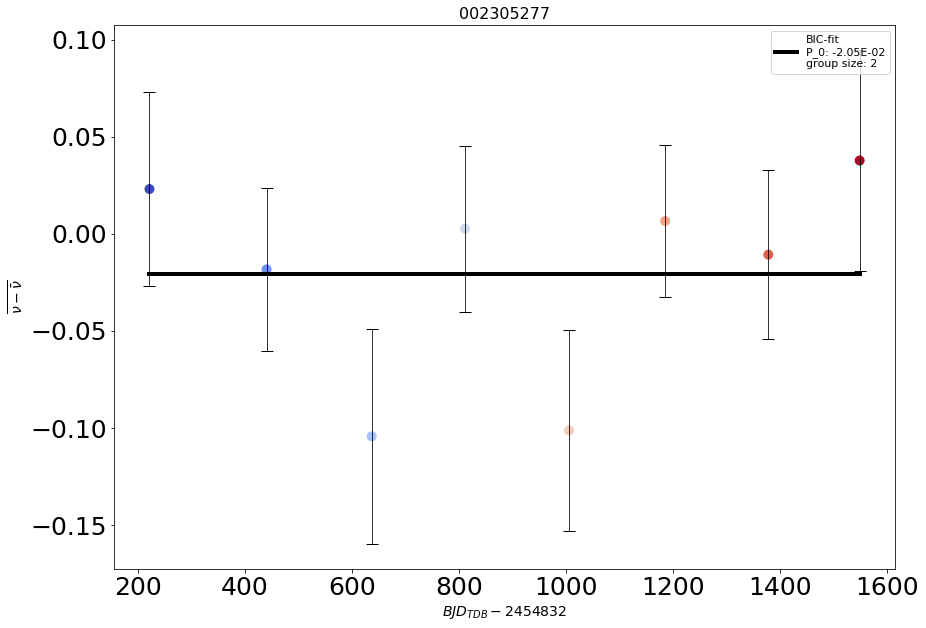

-36.01618395605257
-35.47540691507563


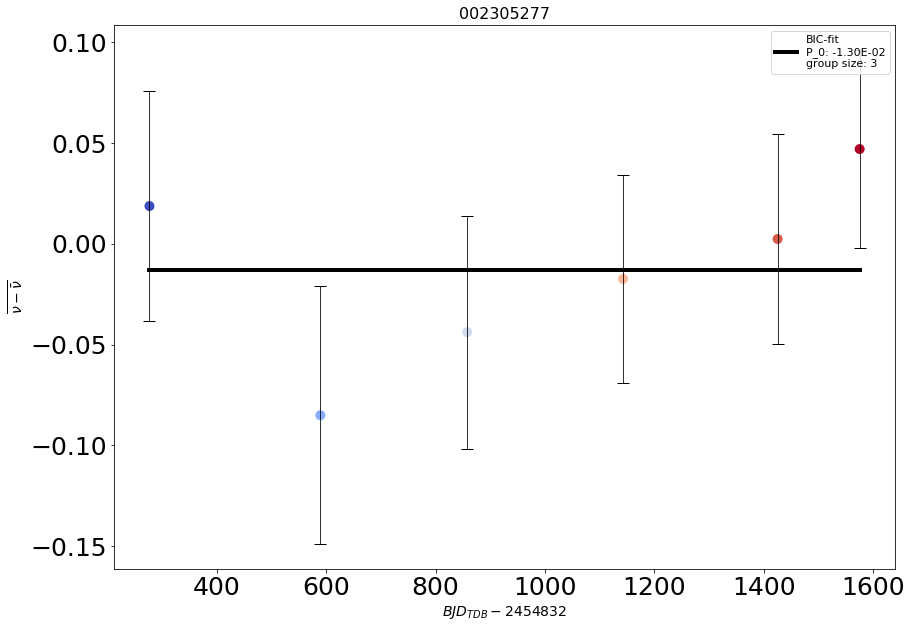

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:388: RuntimeWarning: invalid value encountered in log10
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:388: RuntimeWarning: invalid value encountered in greater_equal


-21.76064969340482
-19.591125504210254


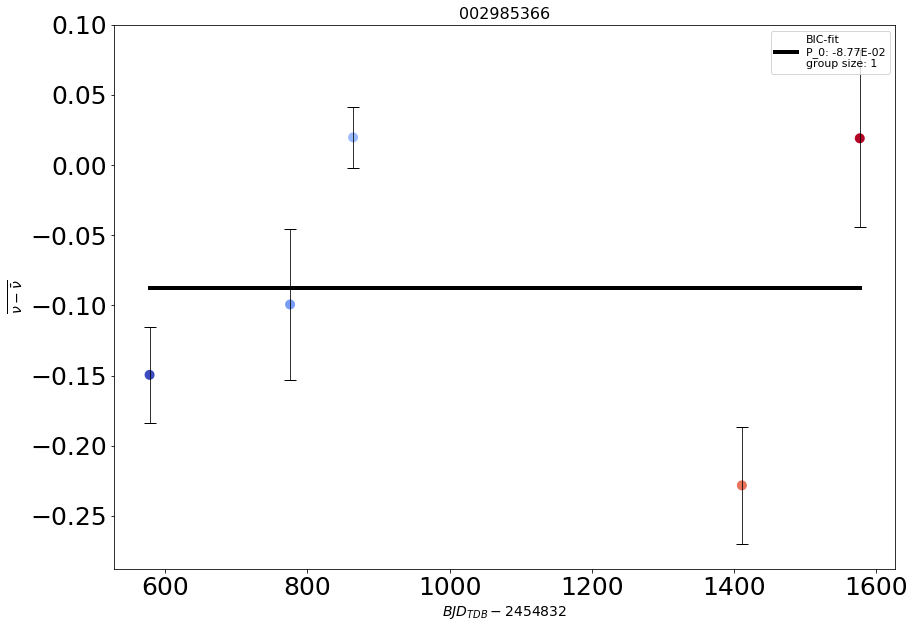

-15.446768725558515
Couldn't fit the BIC eval polynomial


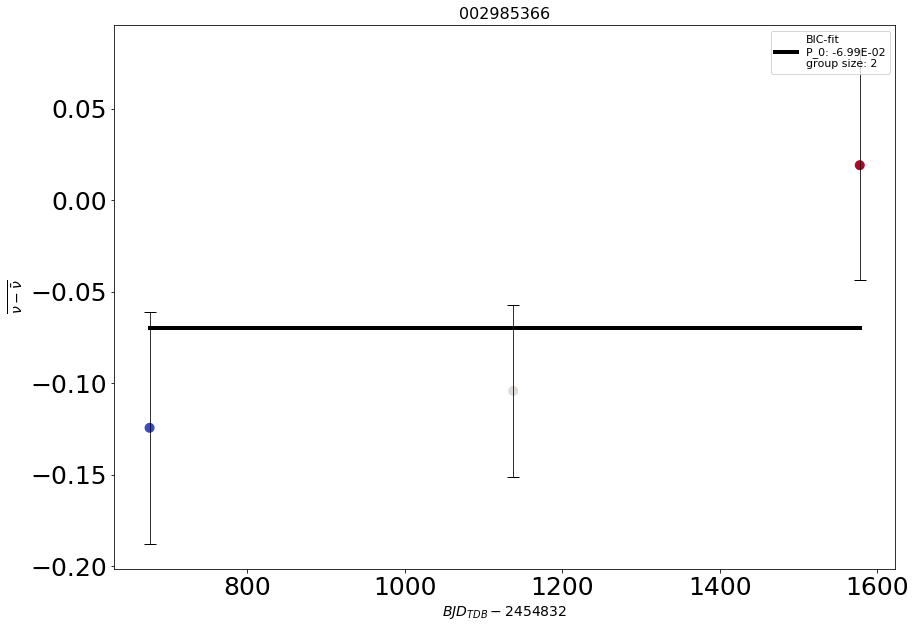

-16.349850783929934
Couldn't fit the BIC eval polynomial


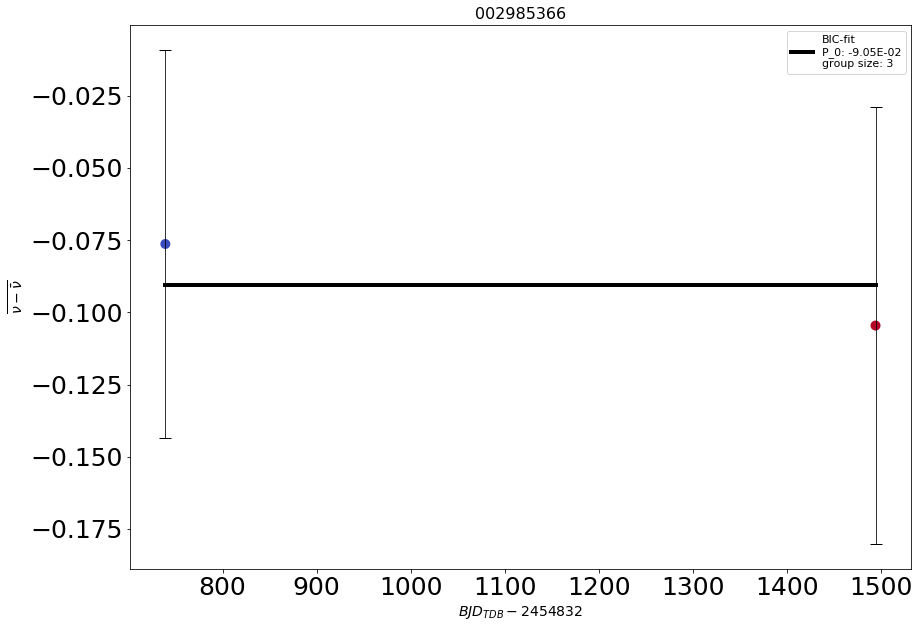

-115.51981864668716
-112.66051998467216


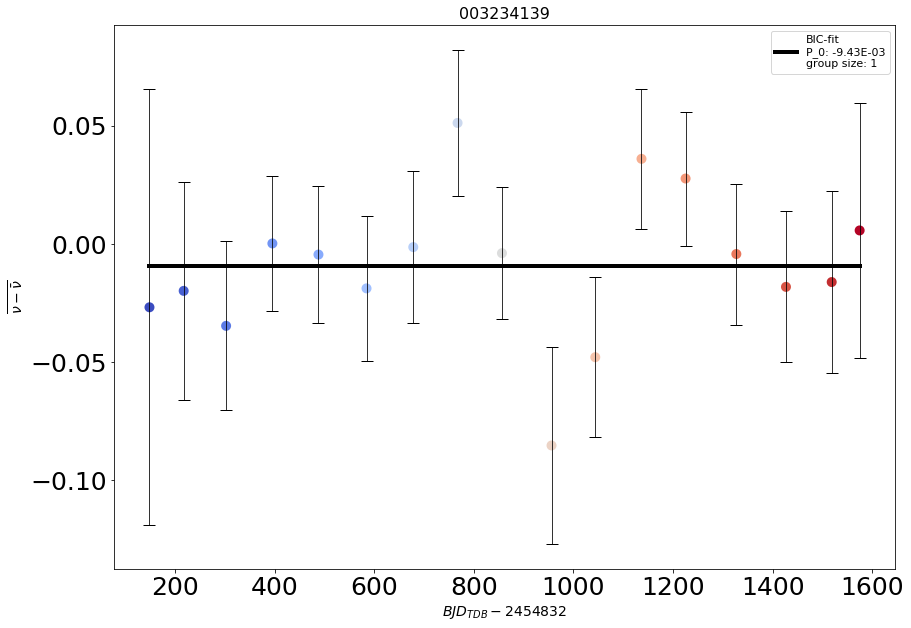

-68.67404034884012
-67.0804304457527


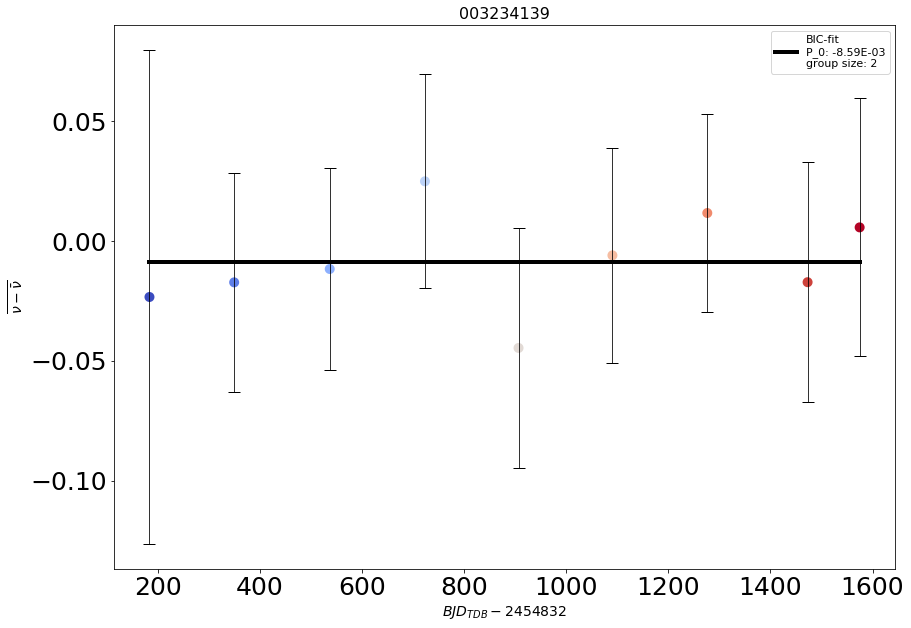

-47.58382007872471
-45.656902725761164


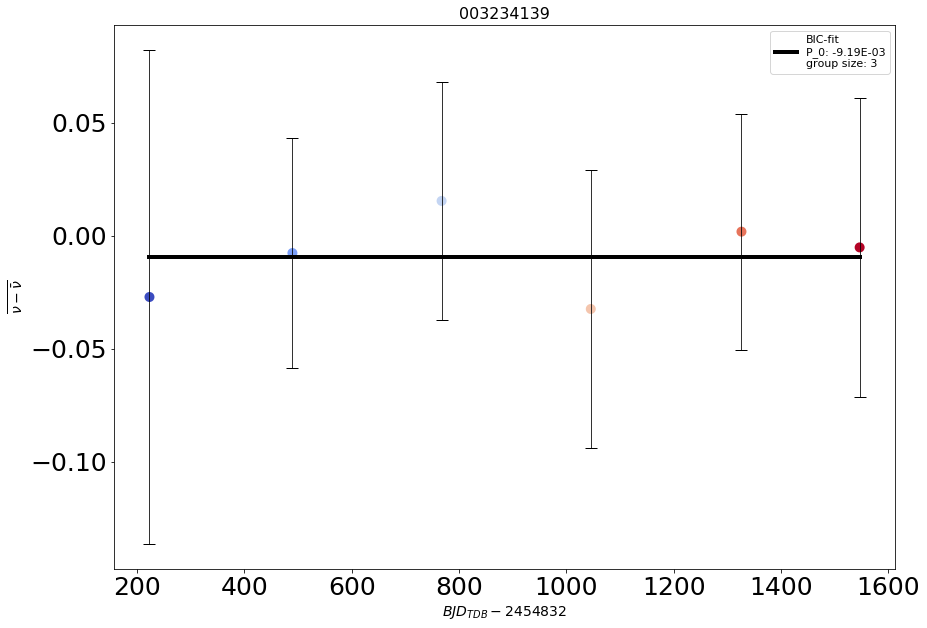

-115.35227427494415
-111.57913576192477


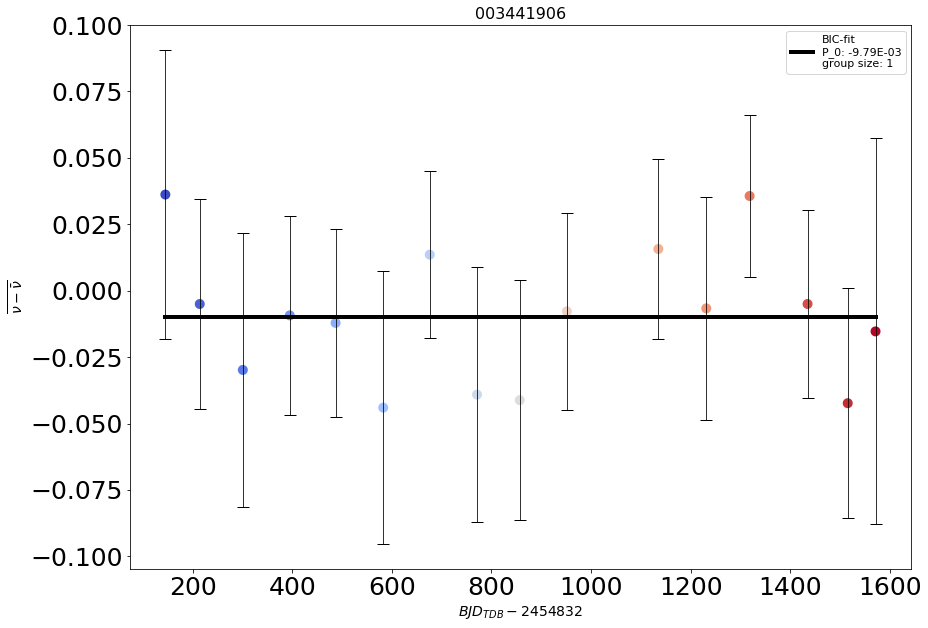

-62.49690820501204
-59.54510832110964


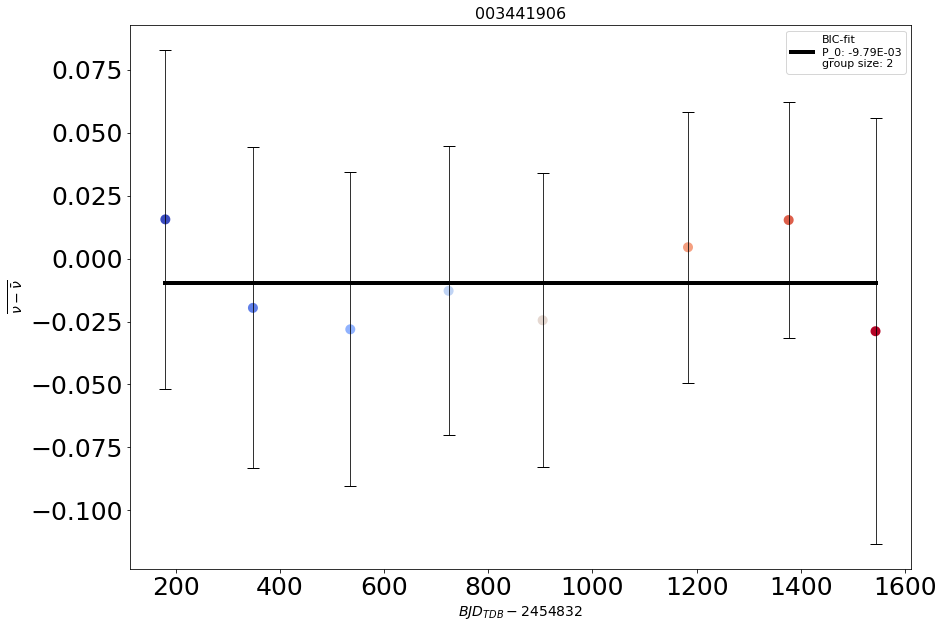

-53.756813592873044
-51.87997161727513


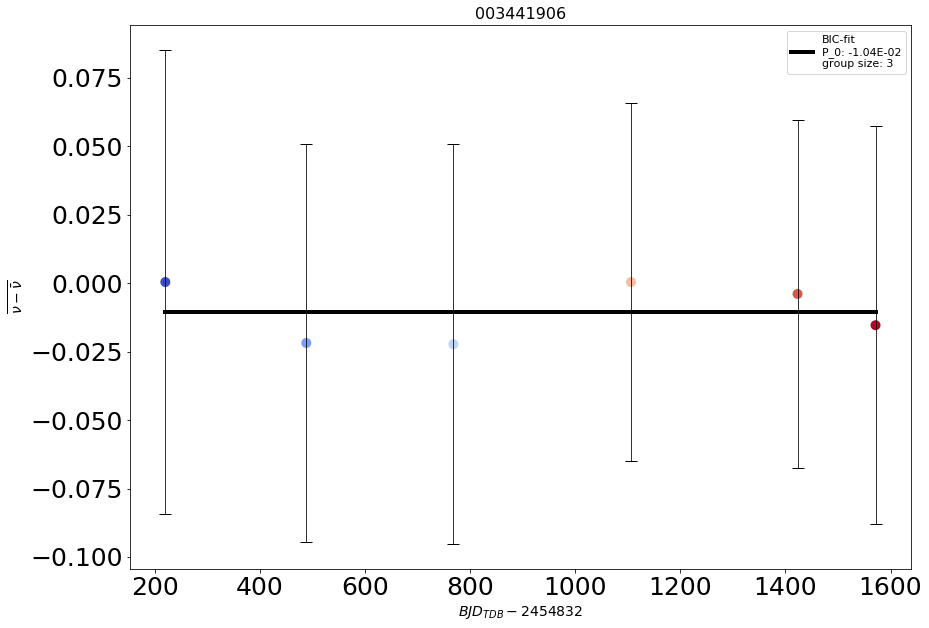

-118.28053461012225
-116.50385514764862


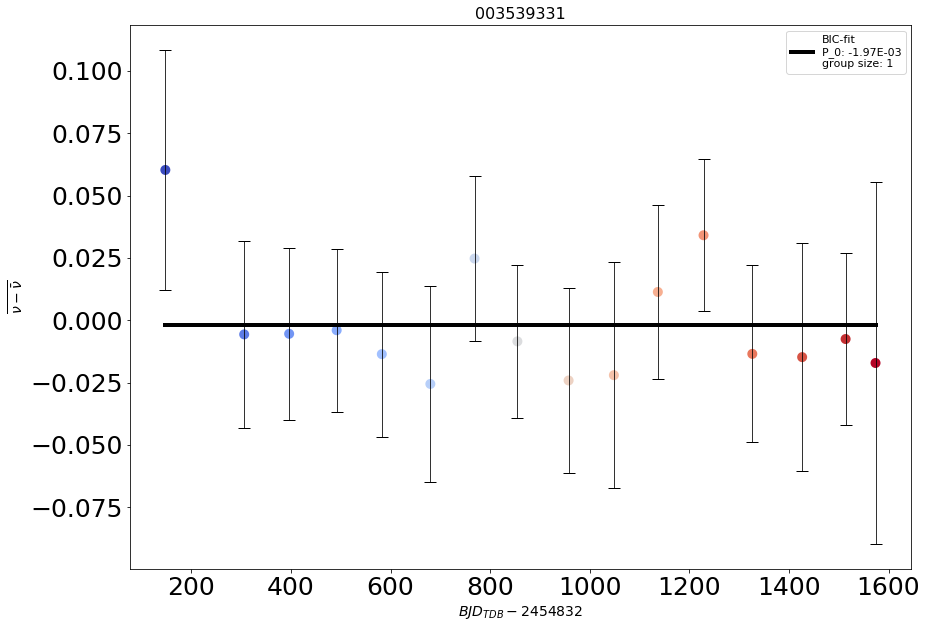

-62.20886212892706
-60.93386098571612


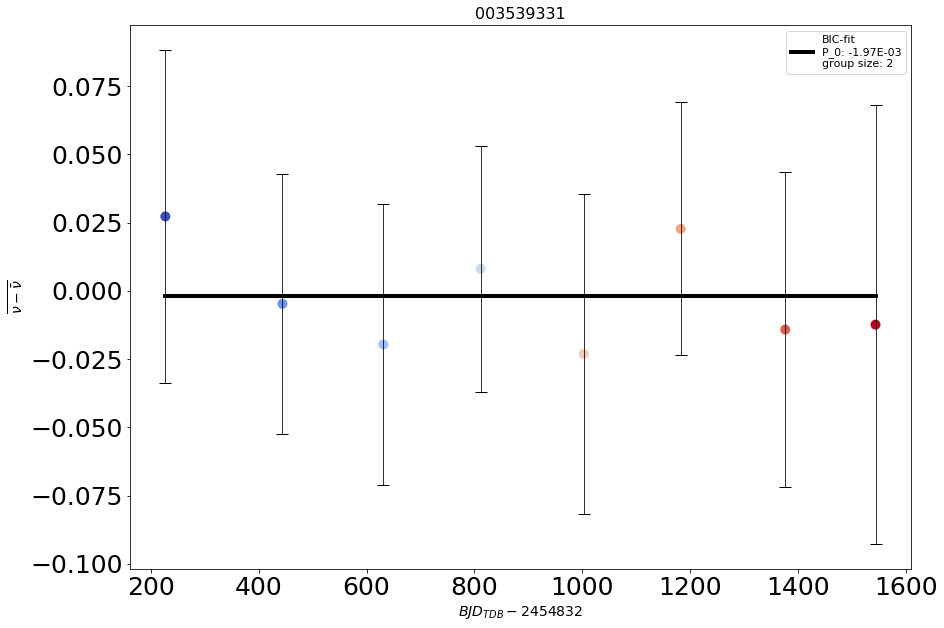

-51.03629702424344
-51.77881207107403
-50.00010184956084


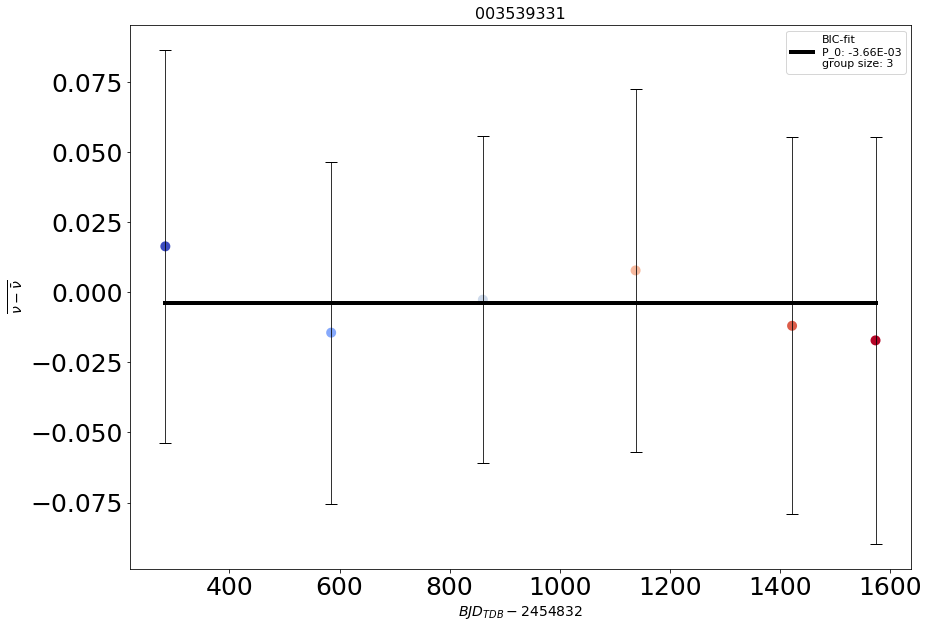

-99.69995085213945
-98.49297796926253


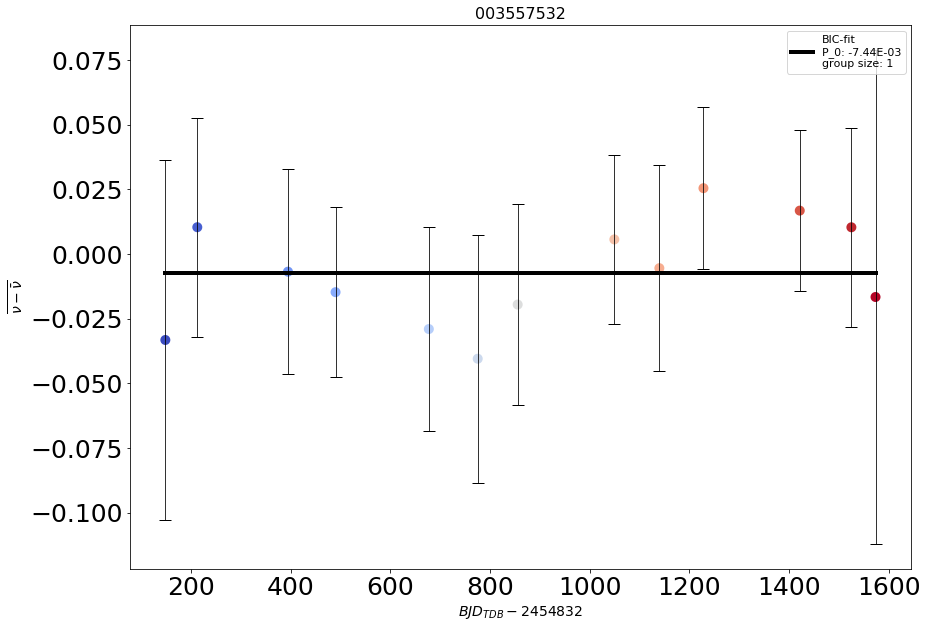

-56.7459589642646
-55.0486313004834


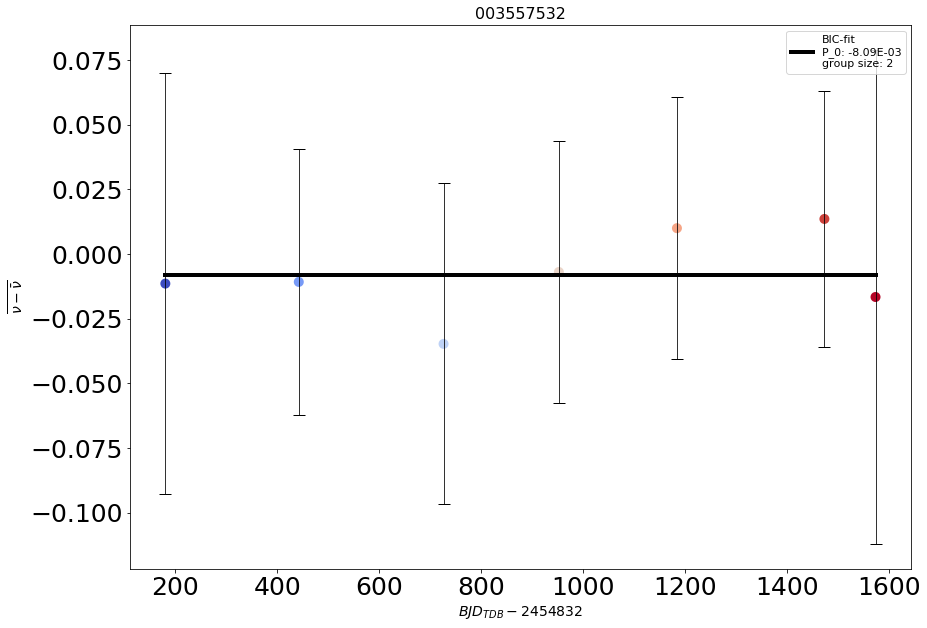

-40.354606762936534
-38.67993495212804


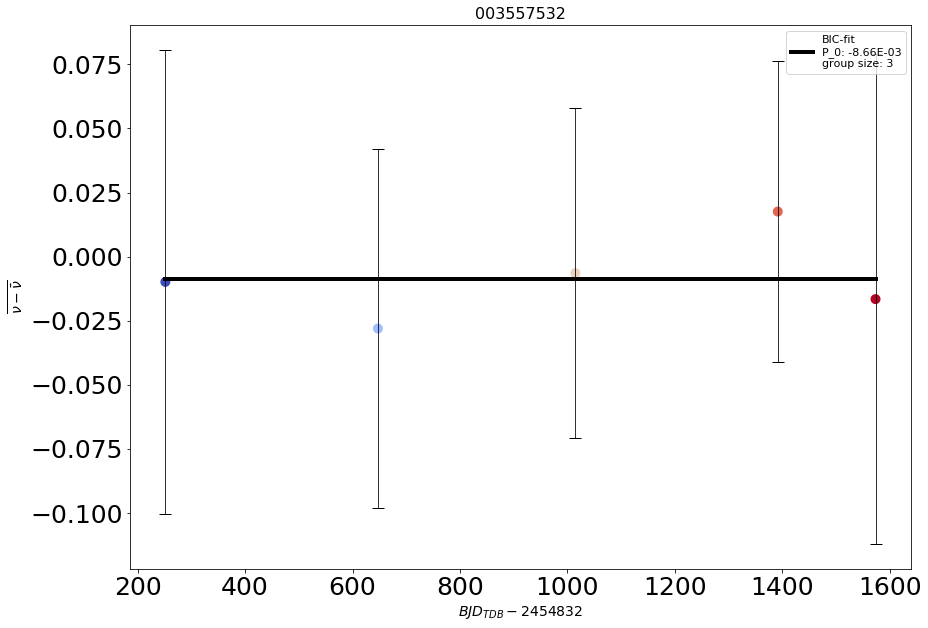

Couldn't fit an exp_decay to 003832966. Skipping further evaluation, moving on to the next KIC
-114.70369764165332
-112.18375081802768


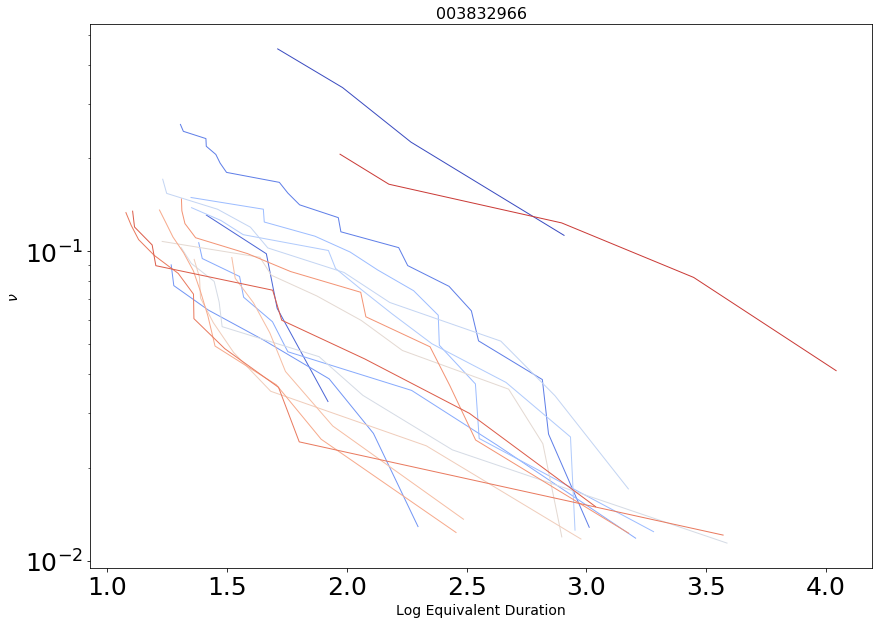

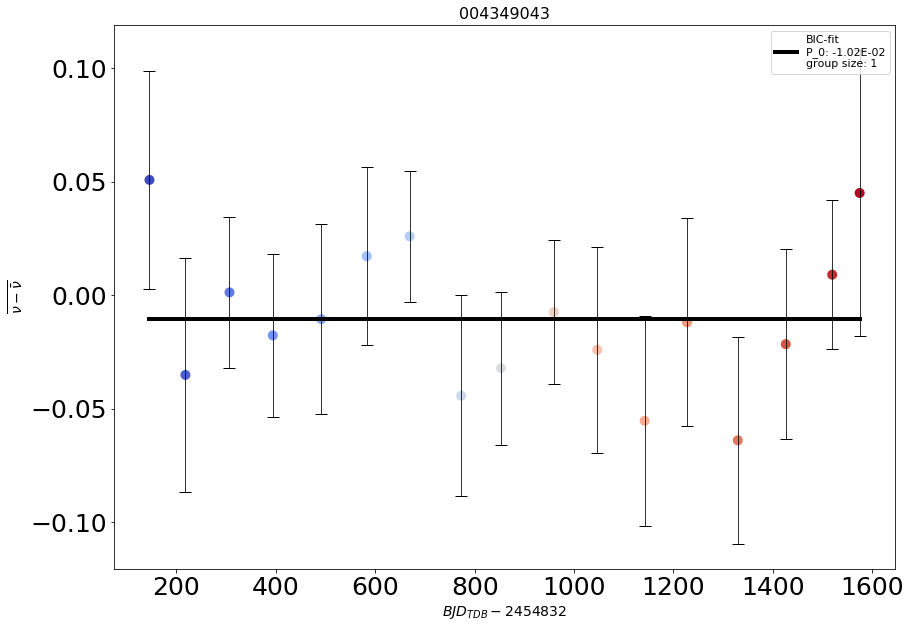

-64.85941431878628
-62.66340957009624


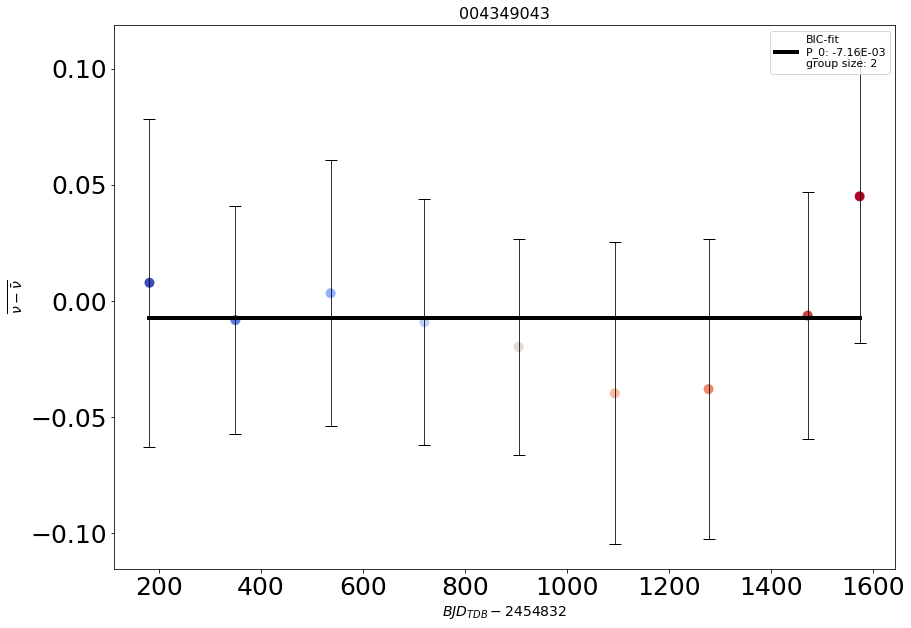

-44.79525209962722
-42.98005167959356


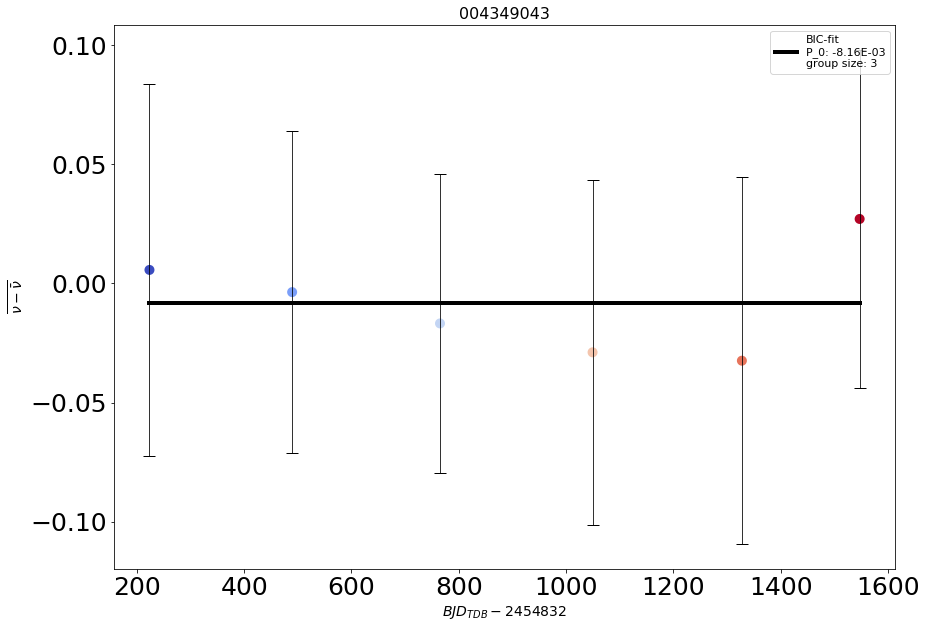

-78.48510424954449
-76.25944832792528


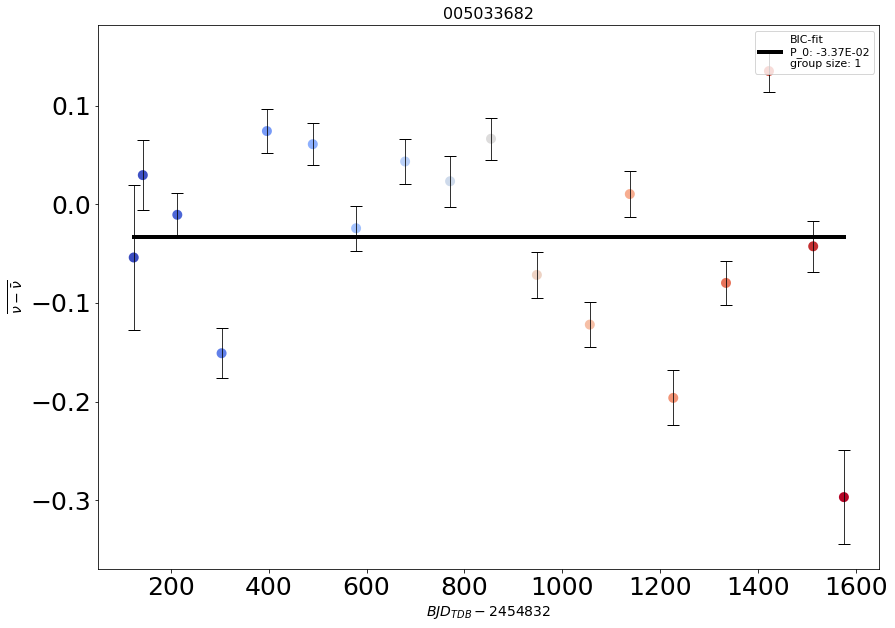

-44.419307699223026
-43.42409796173031


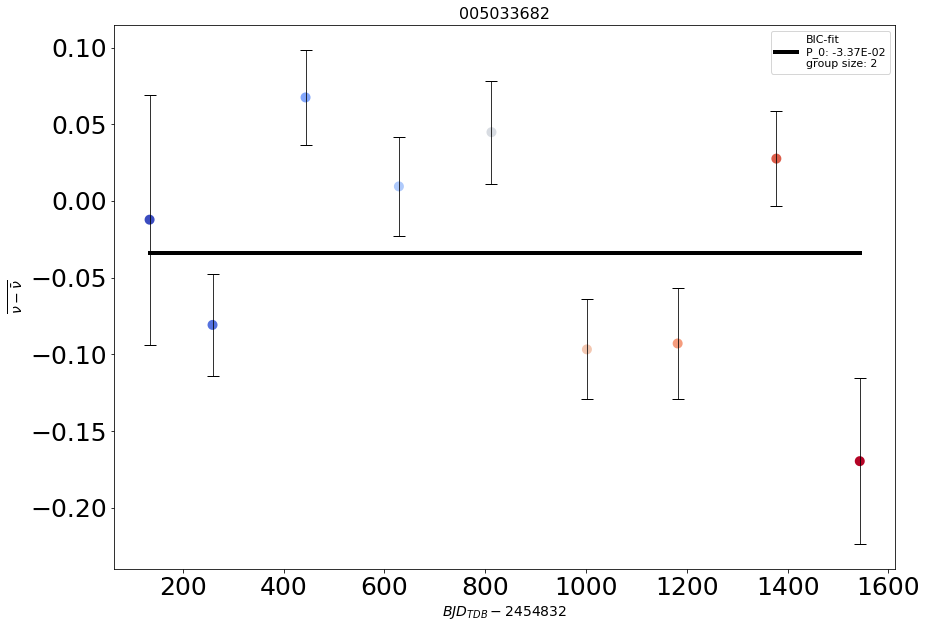

-38.05150963792581
-41.64580222794266
-40.92298201579802


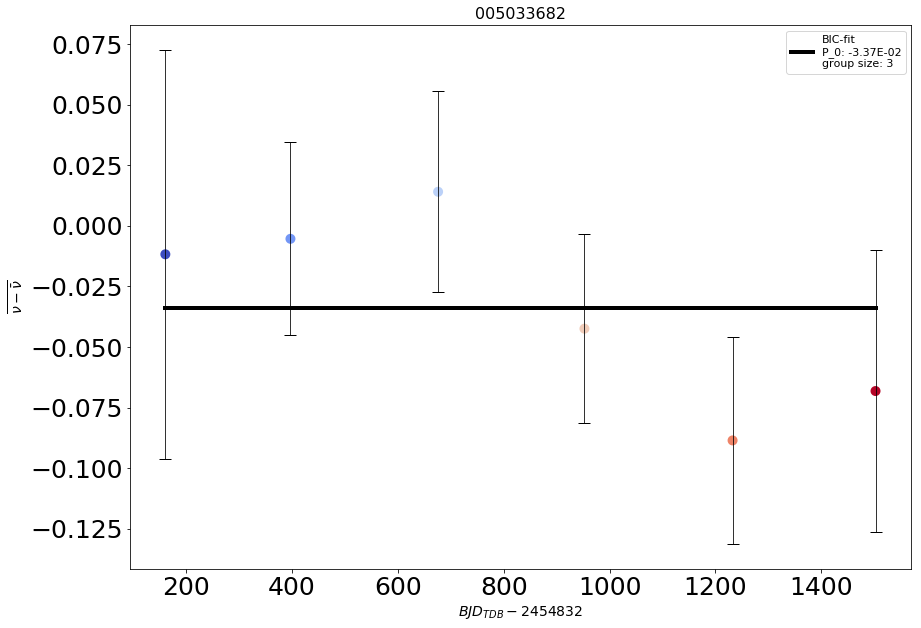

-76.54776035043666
-79.58965236862112
-76.71036756862568


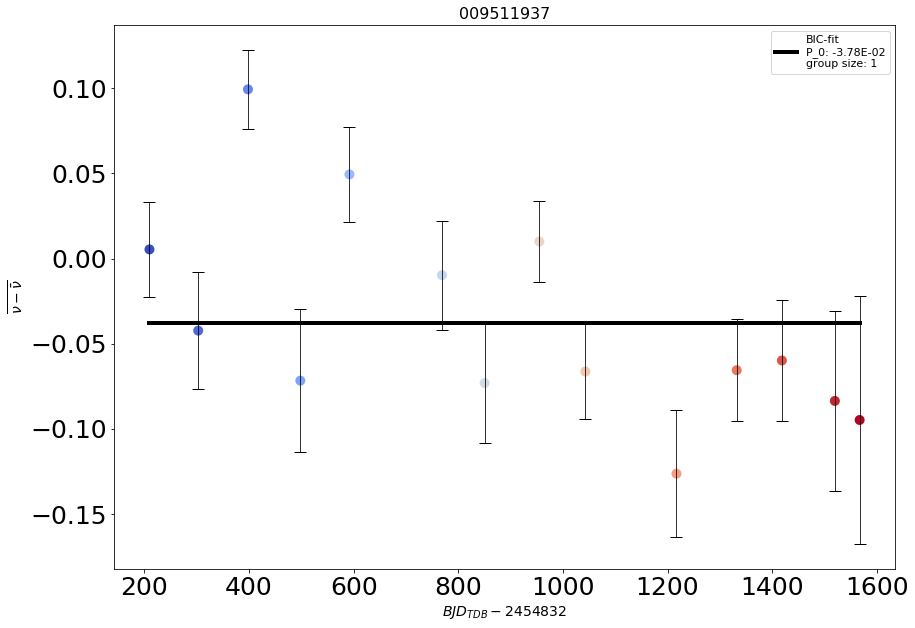

-42.03930892467951
-47.24108264866243
-45.59372212354549


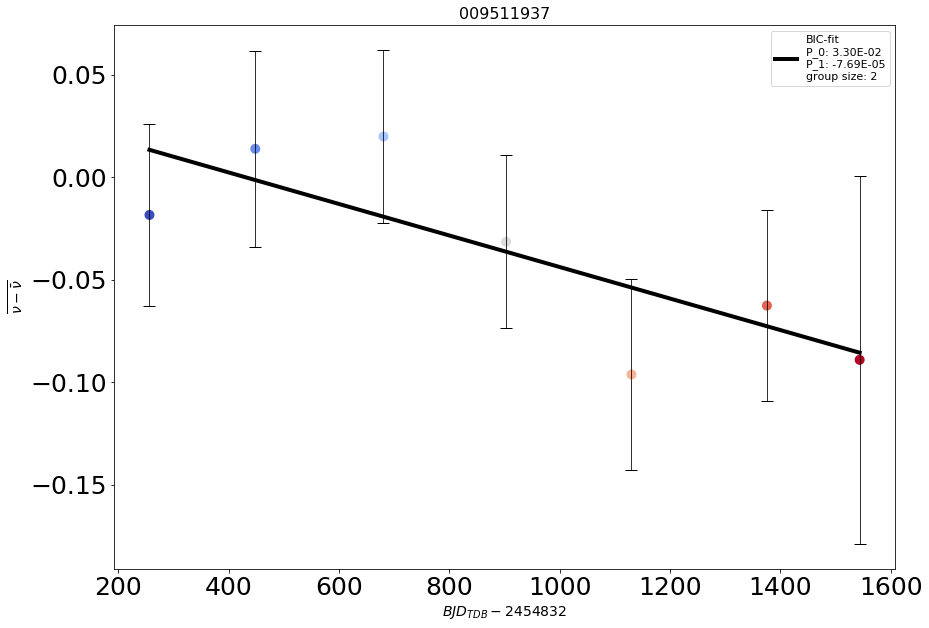

-30.050547921073335
-49.00336505206112
Couldn't fit the BIC eval polynomial


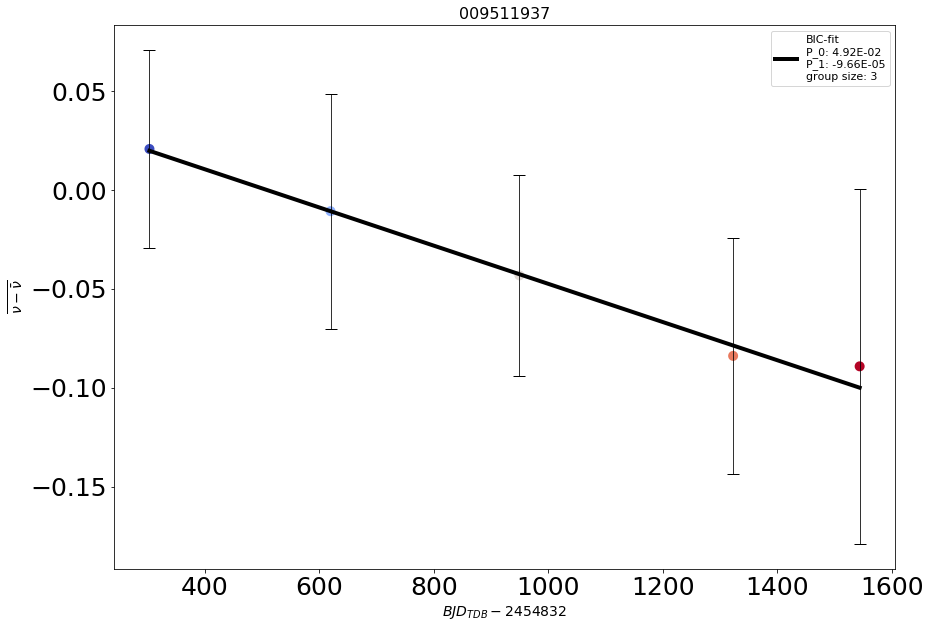

In [126]:
##ENERGY_VS_FREQUENCY##
grouping_nums = [2,3]

targets = open(file, "r") # a file containing all the KICs we want to plot
targetCount = getSize(file) #getting the number of targets using the target file
EVF_Mean_Fit_Data = np.zeros((targetCount*(len(grouping_nums)+1) + 2, 17), dtype='O') #what will become the data file containing all of our EVFMean fit information
EVF_Mean_Fit_Data[0] = ["#This is a file containing the parameters and errors involved in the best fit of a KIC's time vs frequency data",'','','','','','','','','','','','','','','','']
EVF_Mean_Fit_Data[1] = ["#KIC", 'N','group size', 'best degree', 'chiSquare', 'X^3', 'X^2', 'X^1', 'X^0', 'Error3', 'Error2', 'Error1', 'Error0', 'BIC3', 'BIC2','BIC1','BIC0']
targetIndex = 2


for line in targets: #going through each KIC
    KIC = line.rstrip('\n') #stripping the return off each line
    files = sorted(glob('KICs/'+KIC+"/*.flare")) #Glob all of the files in the directory - get all flares for a star
    fileCount = len(files)
    quarterlyEVFX, quarterlyEVFY, popt, perr, toteDuration, time, offset, success  = plot_energy_vs_frequency(KIC, files, fileCount, showe=SHOWE,errore=ERRORE,whole=WHOLE,save=SAVEPLOT)
    if(success):
        meanValues, mean_errors = plot_energy_vs_frequency_subtraction(KIC, quarterlyEVFX, quarterlyEVFY, popt,perr, offset, toteDuration,showes=SHOWES, save=SAVEPLOT)
        plot_time_vs_mean_frequency(KIC, time, meanValues, mean_errors, EVF_Mean_Fit_Data, targetIndex,errorm=ERRORM,showm=SHOWM,save=SAVEPLOT)
        targetIndex+= 1
        for group_size in grouping_nums:
            plot_time_vs_mean_frequency_grouped(KIC, time, meanValues, mean_errors, group_size, EVF_Mean_Fit_Data, targetIndex,errorm=ERRORM,showm=SHOWM,save=SAVEPLOT)
            targetIndex+= 1

    
targets.close()

if(SAVETXT==True):
    np.savetxt(EVFMfitData+'/fit_data_for_EVFM.txt', EVF_Mean_Fit_Data, fmt = '% 20s', delimiter=' ', newline='\n', header='', footer='', comments='# ')

-36.18809753249831
-36.90892131750515
-35.09837349076326


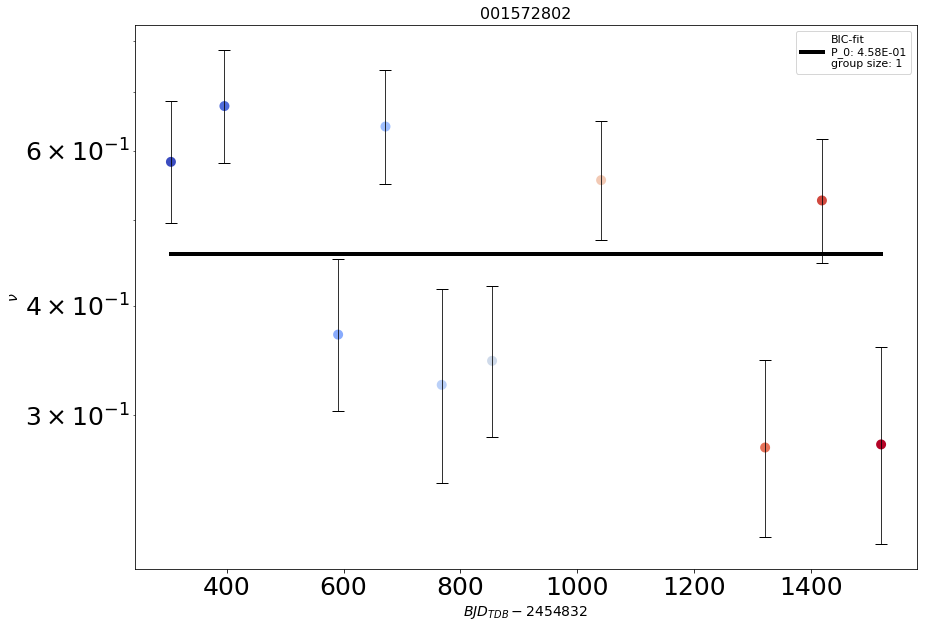

-102.6227687558033
-101.93393947113924


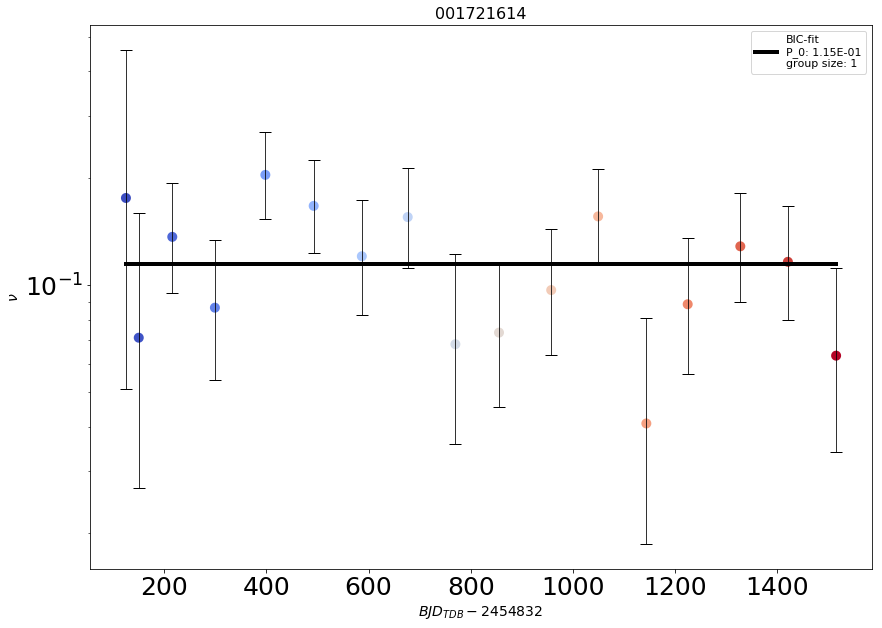

-97.9331008355058
-103.1327278445912
-104.280388584757
-102.4794525623646


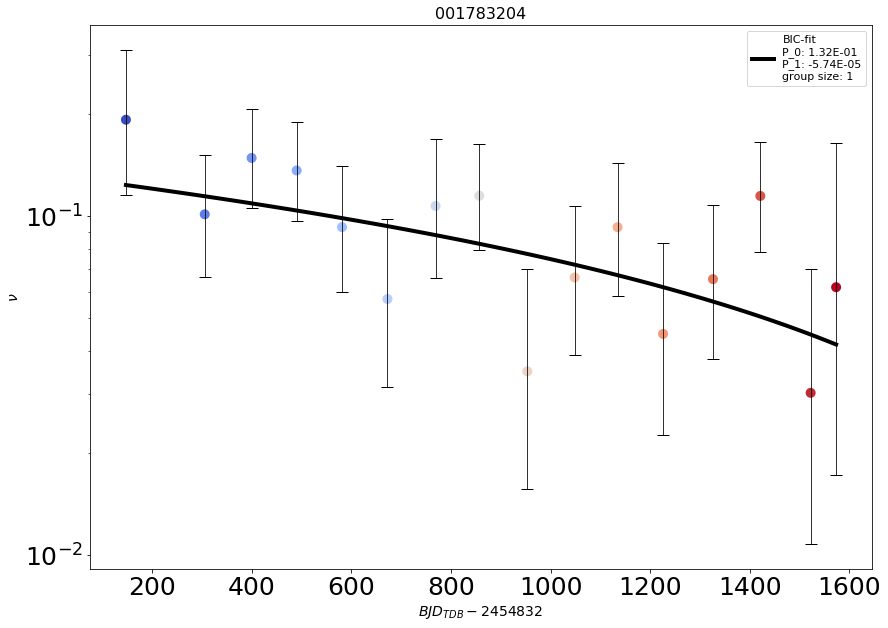

-32.444532411519496
-29.827003850629797


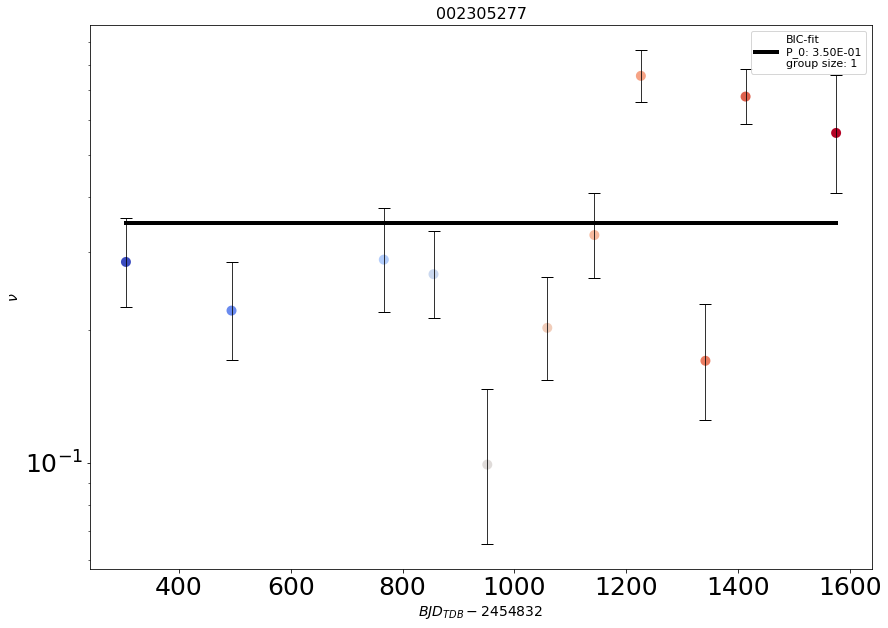

-23.256530305873323
-18.53978382541902


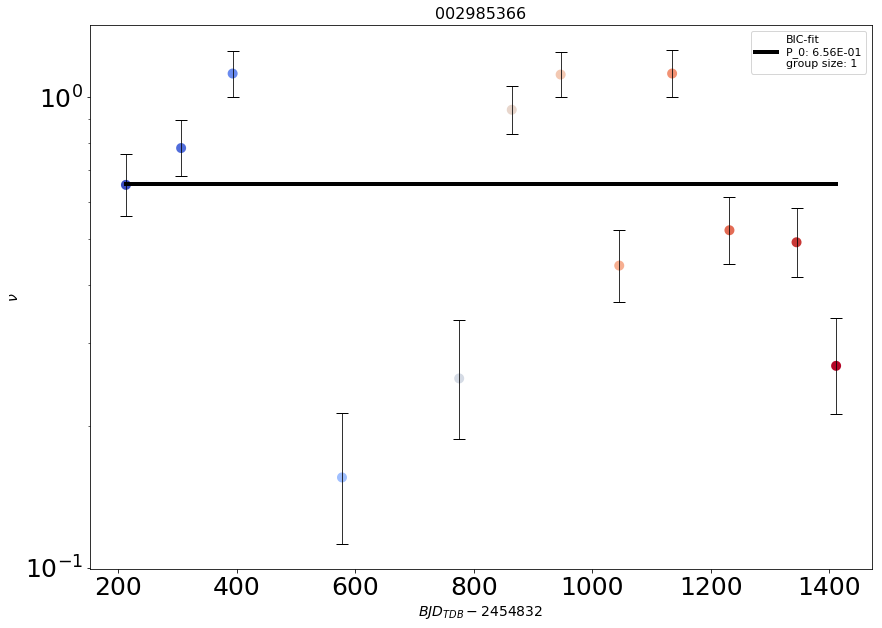

-97.0632290674055
-94.00353252346693


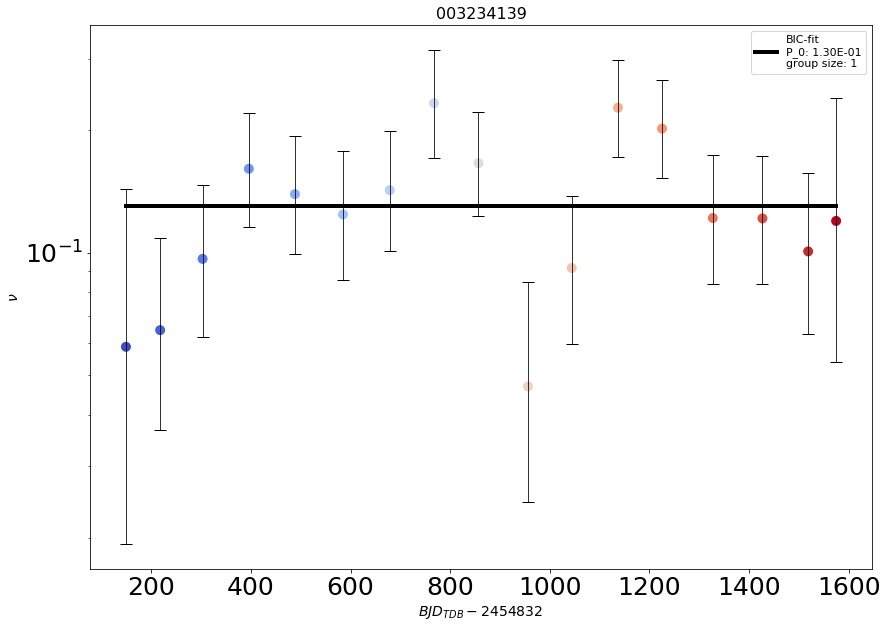

-91.92494448089589
-87.20965899682265


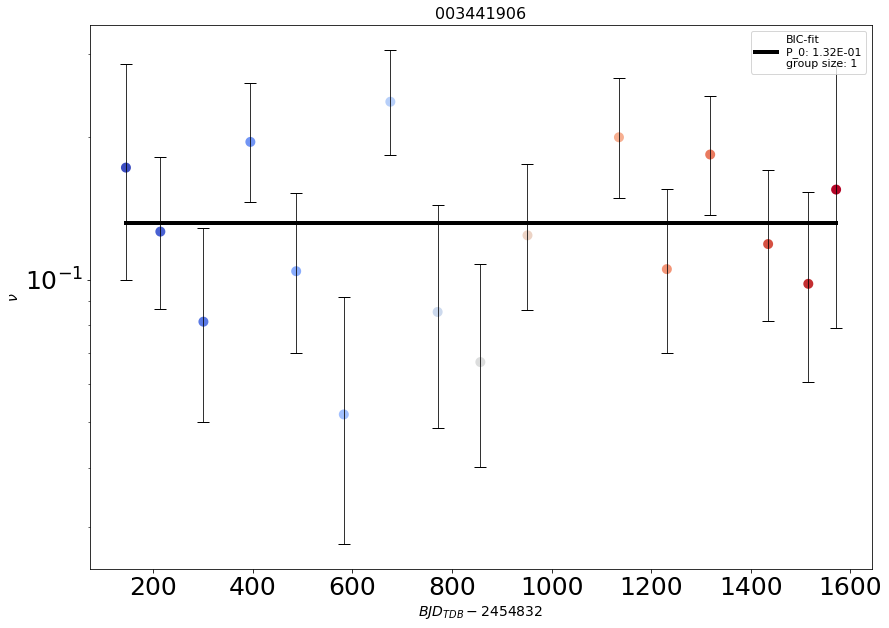

-82.45849172723648
-81.1092061151603


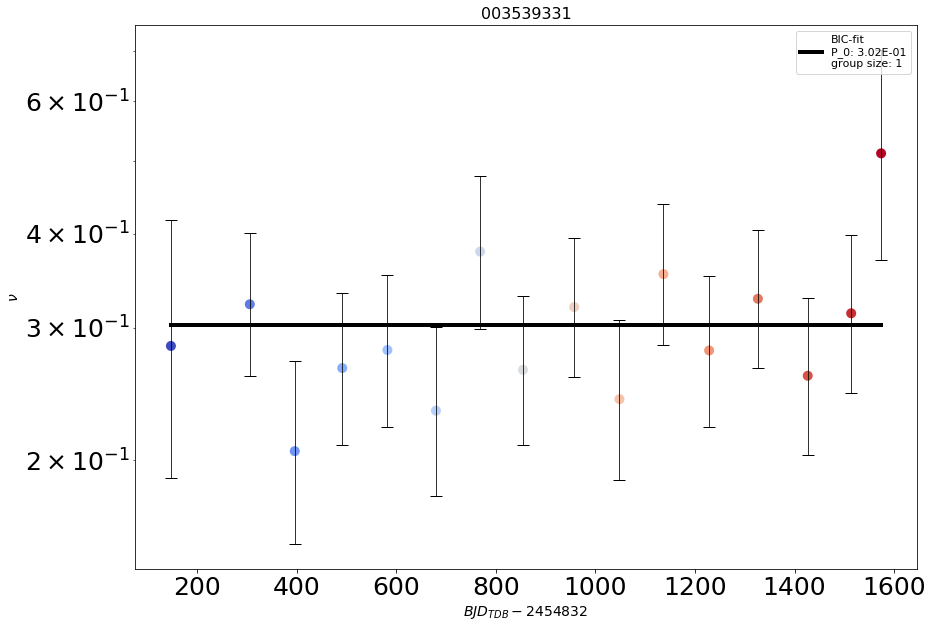

-65.2131068648793
-70.88260431491422
-68.95619676404961


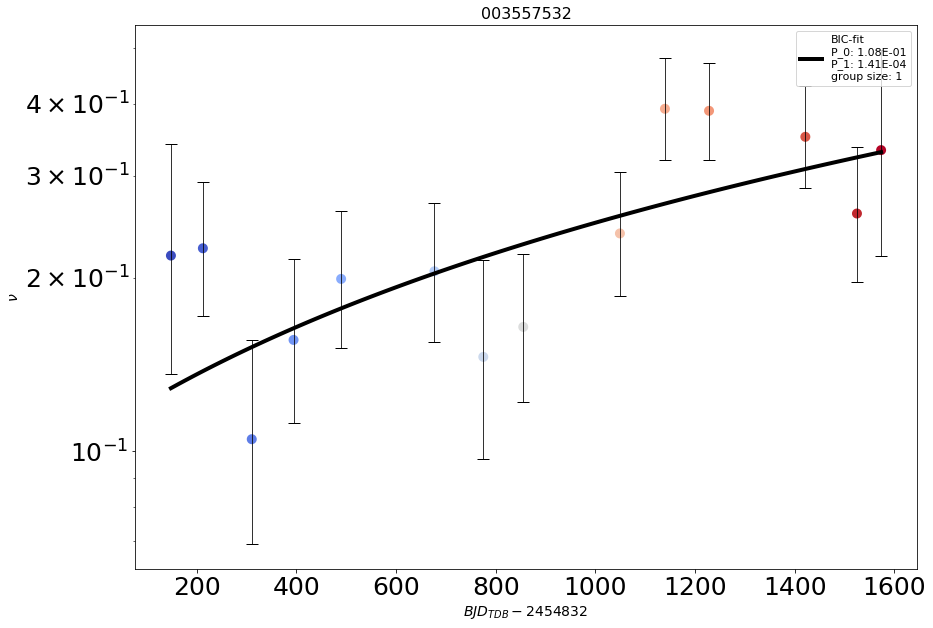

-60.642296099893635
-57.02291101913802


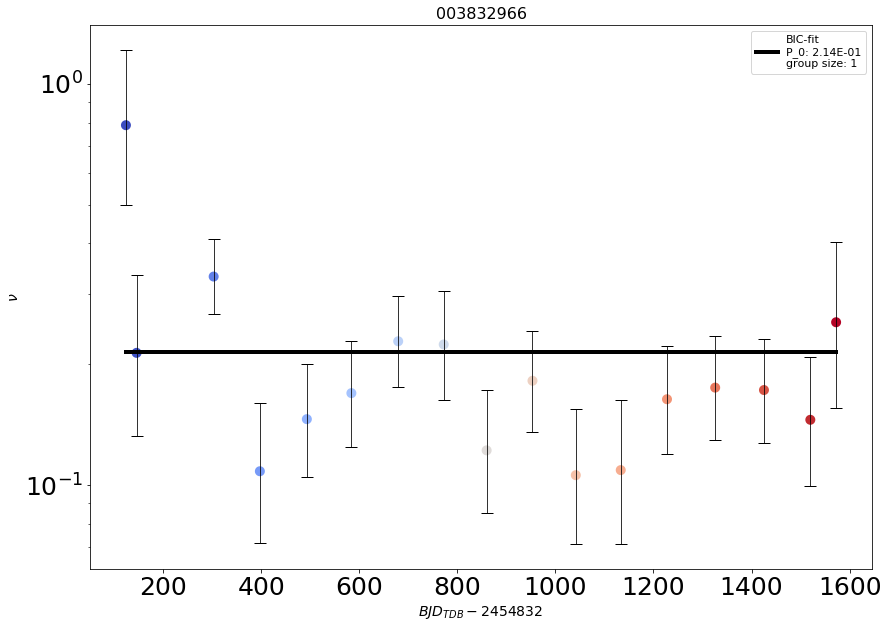

-94.45125567490228
-90.69802036421187


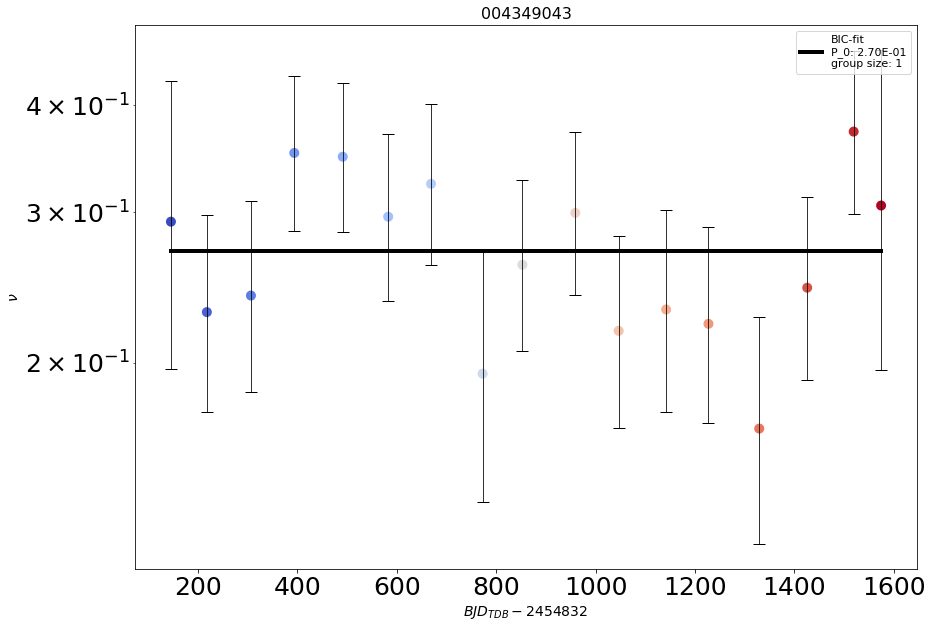

-40.51278442252933
-38.03128761953867


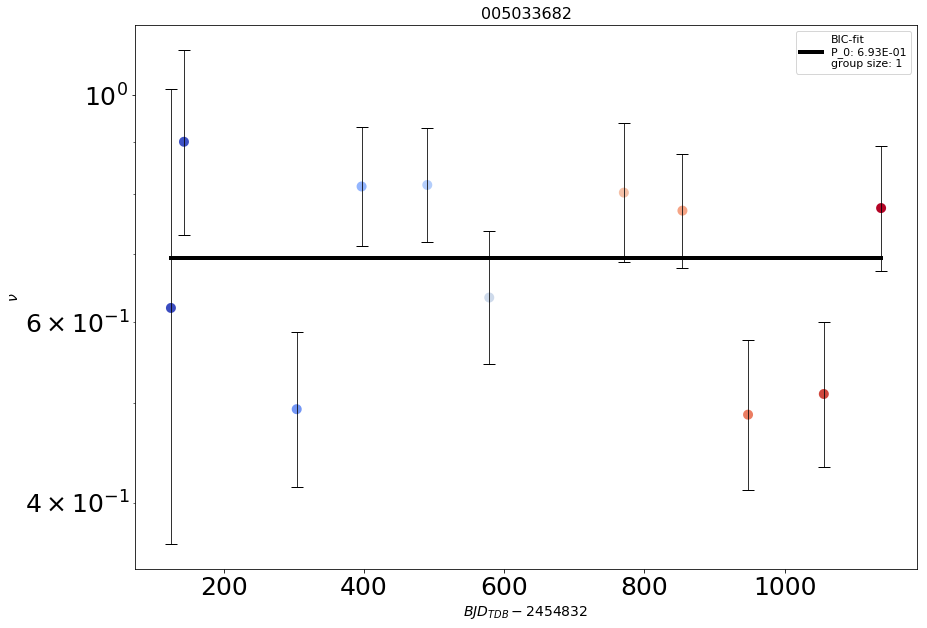

-42.52675679948566
-50.122700807673134
-47.716198871761904


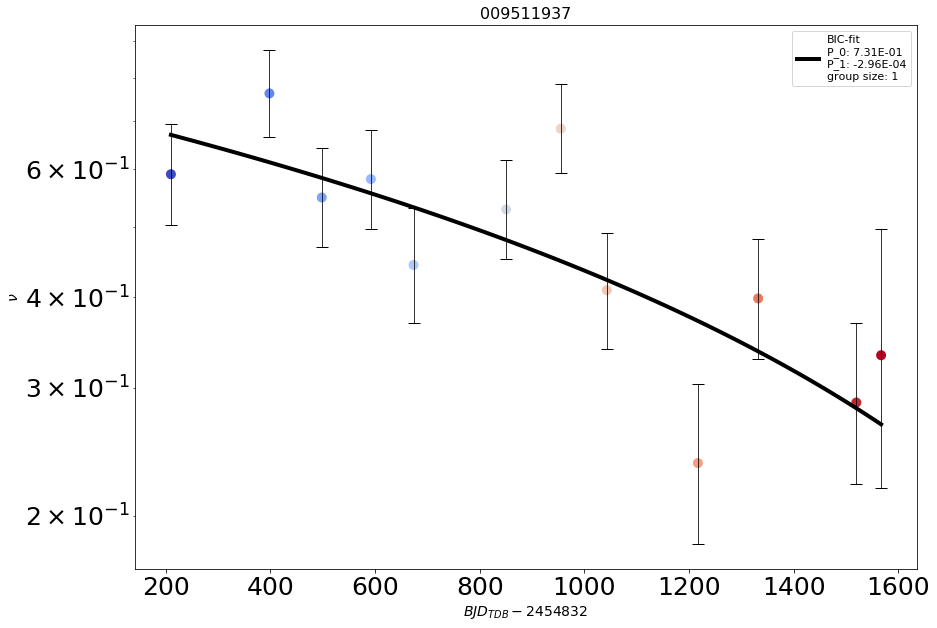

-67.4551573880936
-63.59123321501632


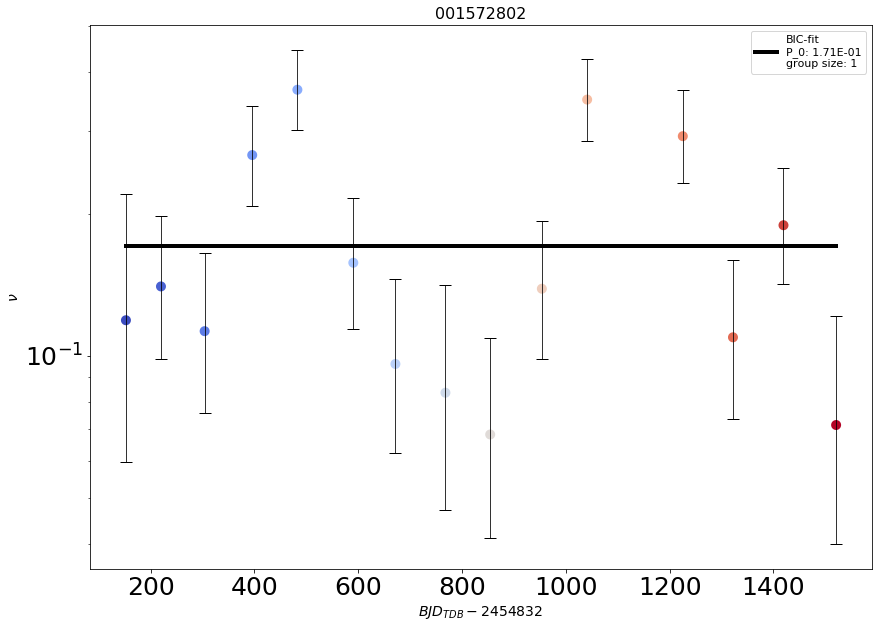

-107.79831223478676
-104.40245943366288


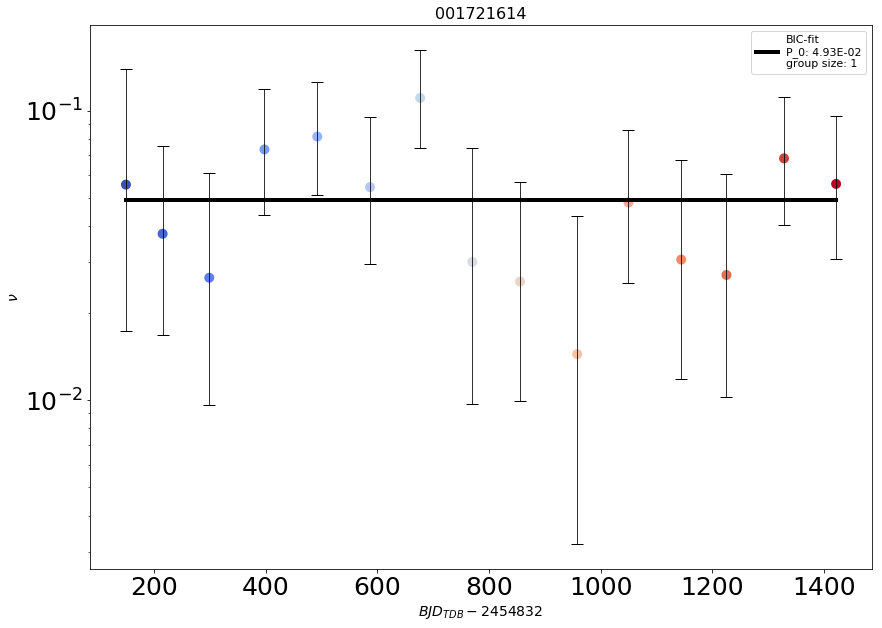

-36.80444324884739
Couldn't fit the BIC eval polynomial


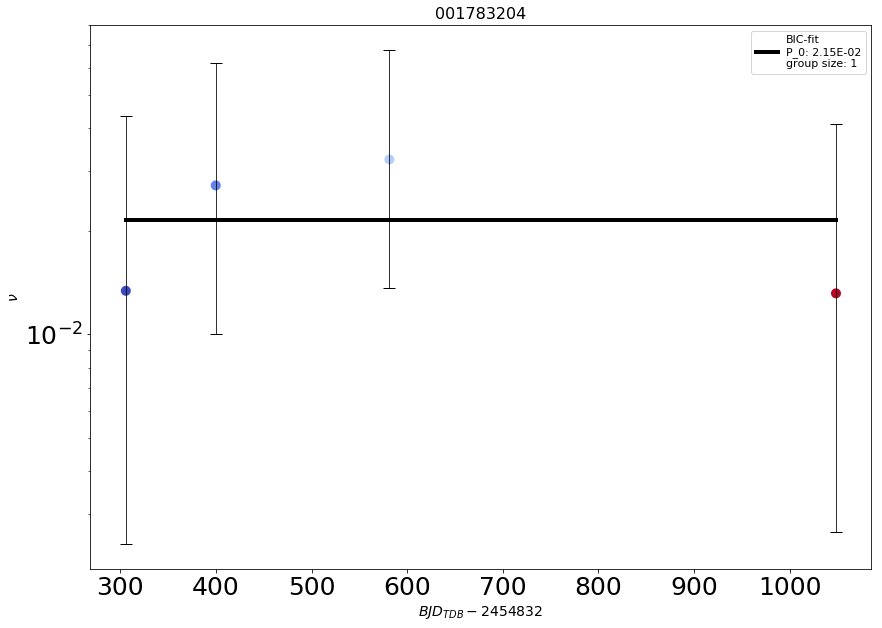

-66.86165449368346
-59.44420347355852


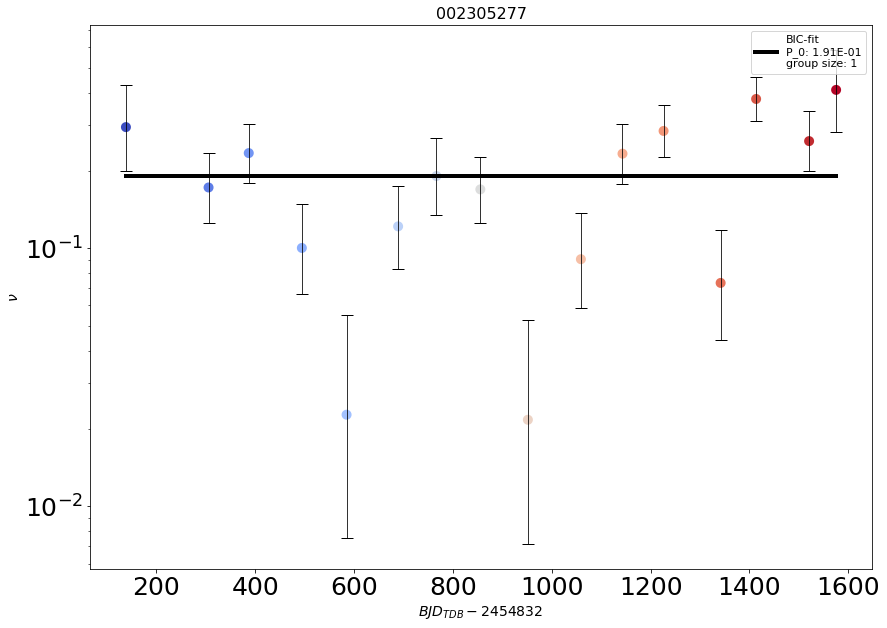

-39.322087501269735
-35.06834604534242


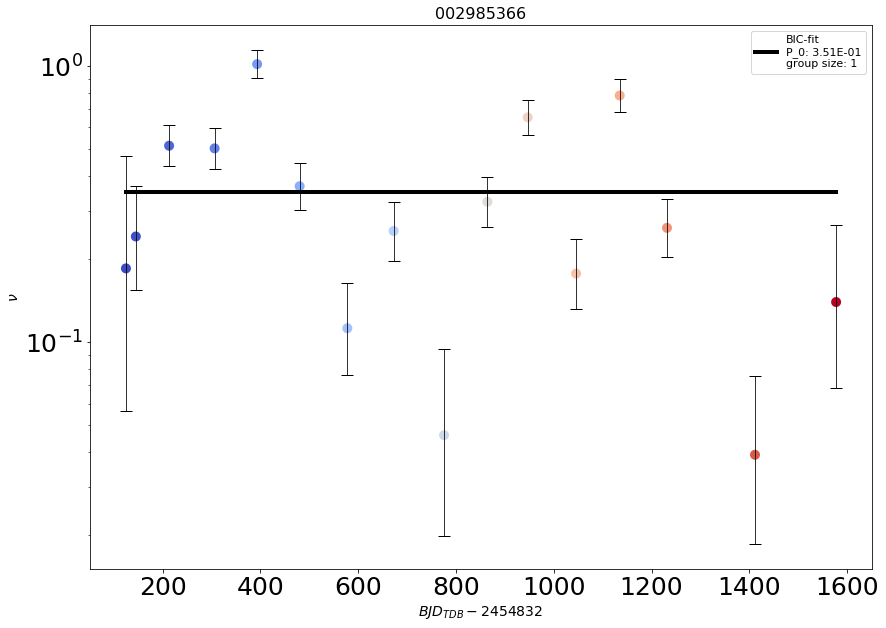

-126.65042456528536
-125.89046608793825


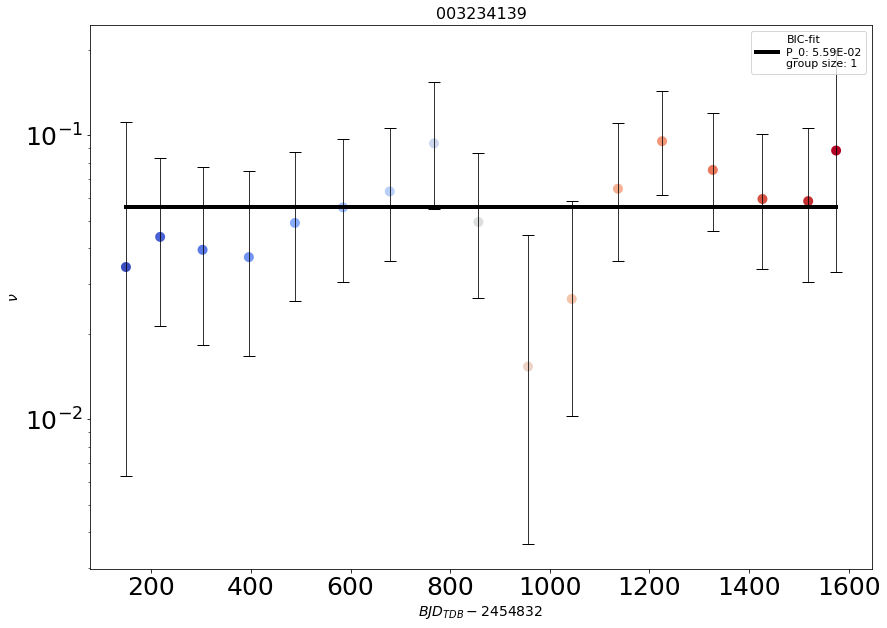

-106.84225050945258
-102.7309598522491


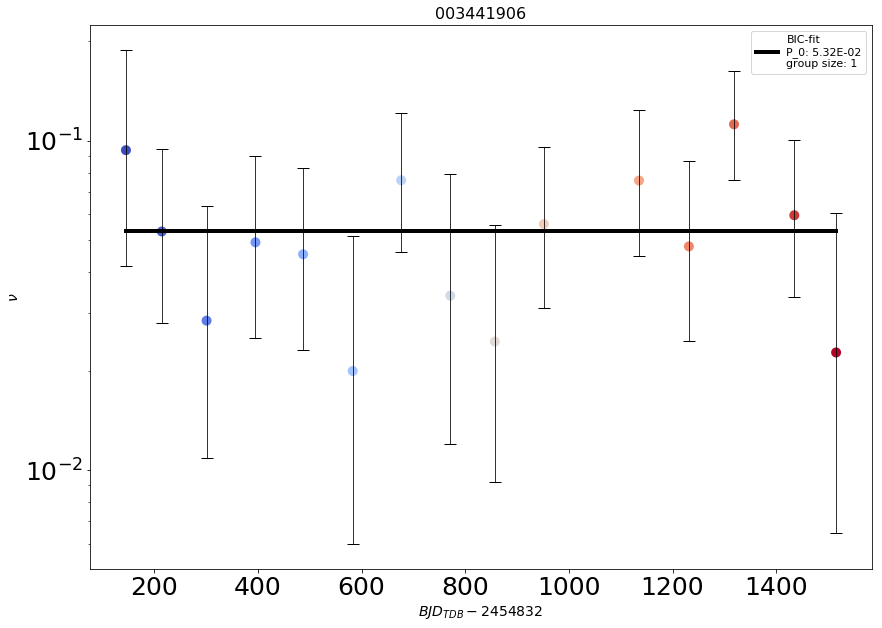

-98.46280264576335
-94.54805987940603


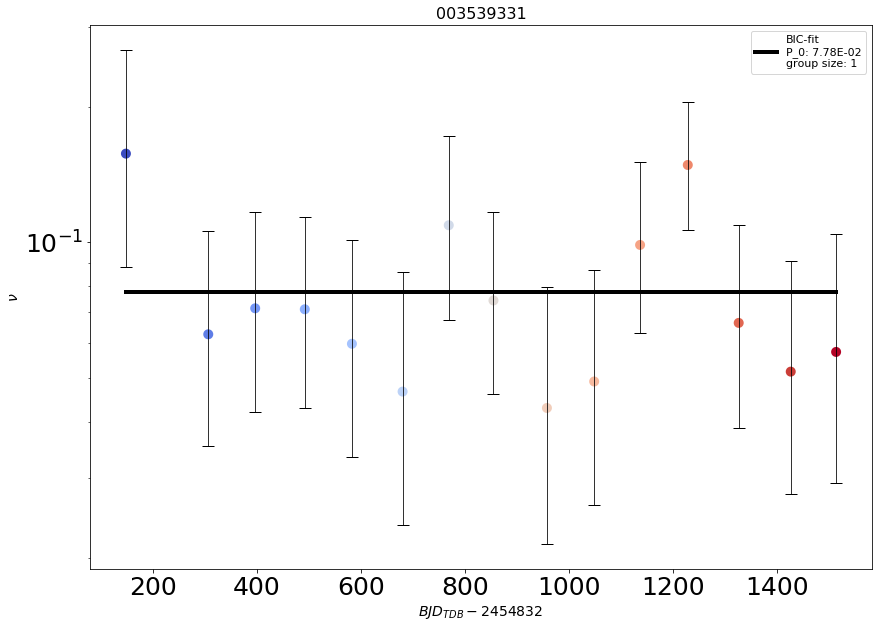

-84.87384779205668
-83.9731786358873


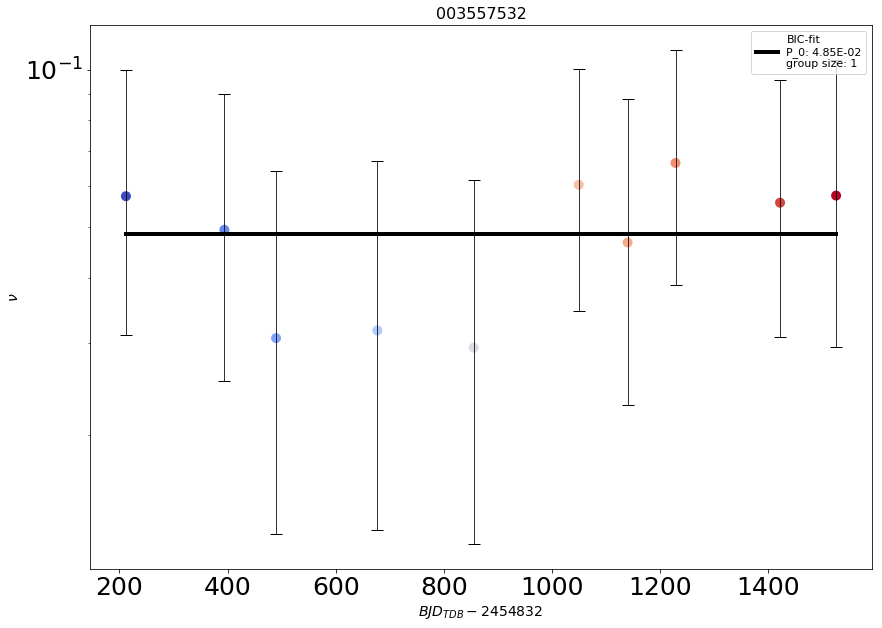

-78.82682252059934
-74.72515362772805


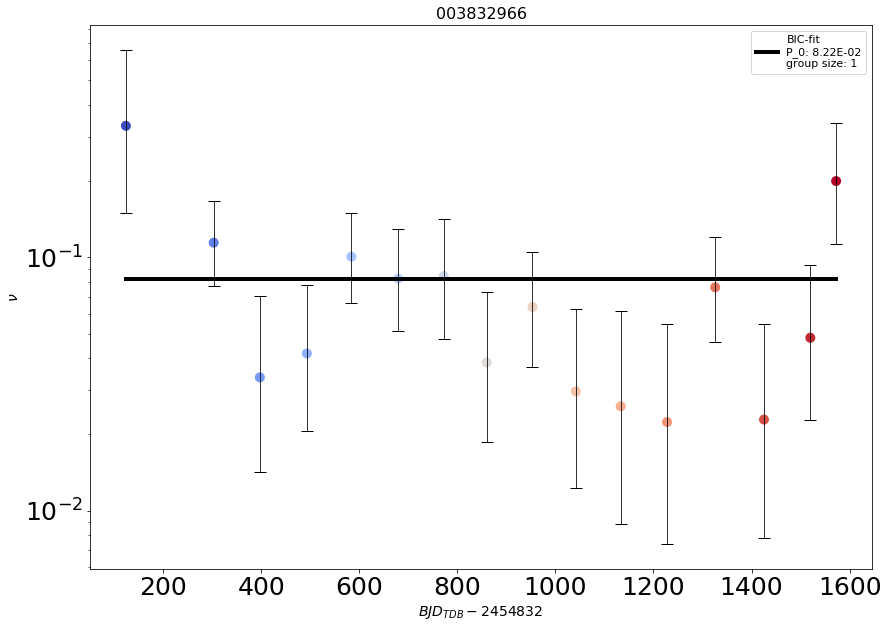

-112.9501460052591
-107.89097736602184


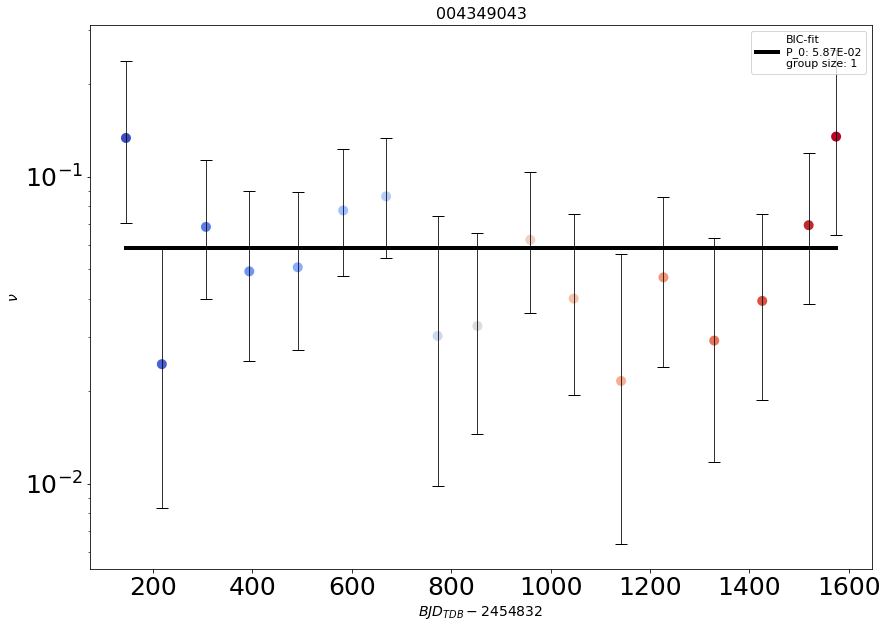

-64.49850043714689
-63.133338541071545


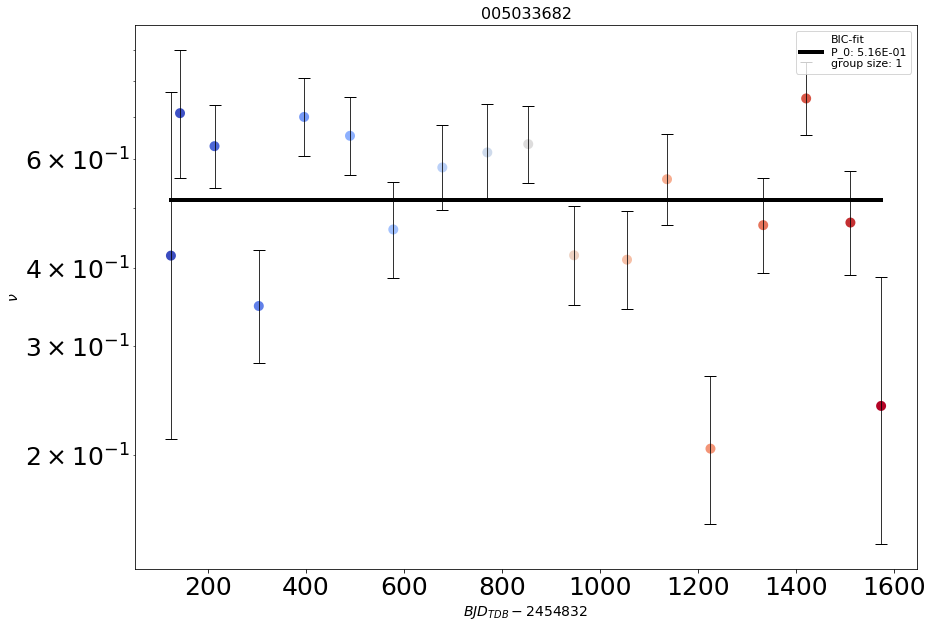

-62.989841964023924
-67.22098029476125
-64.54704098616217


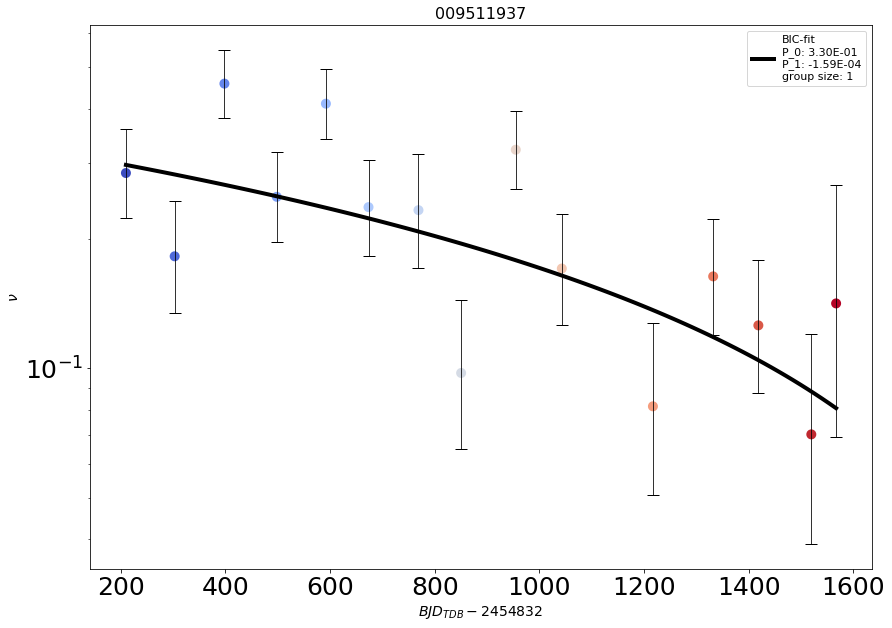

In [127]:
##TIME_VS_FREQUENCY##
energyConstantList = [1,2] #a list containing all of the energies we'll plot TVF at
for energyConstant in energyConstantList:

    targets = open(file, "r") # a file containing all the KICs we want to plot
    fixedEnergy = energyConstant + EPOINT # the fixed energy value
    TVF_Fit_Data = np.zeros((targetCount + 2, 17), dtype='O') #what will become the data file containing all of our fit information
    TVF_Fit_Data[0] = ["#This is a file containing the parameters and errors involved in the best fit of a KIC's time vs frequency data",'','','','','','','','','','','','','','','','']
    TVF_Fit_Data[1] = ["#KIC", 'N', 'group size', 'best degree', 'chiSquare', 'X^3', 'X^2', 'X^1', 'X^0', 'Error3', 'Error2', 'Error1', 'Error0', 'BIC3', 'BIC2','BIC1','BIC0']
    targetIndex = 2

    for line in targets: #going through each KIC

        KIC = line.rstrip('\n') #stripping the return off each line
        files = glob('KICs/'+KIC+"/*.flare") #Glob all of the files in the directory - get all flares for a star
        fileCount = len(files)
        plot_time_vs_frequency(KIC, files, fileCount, TVF_Fit_Data, fixedEnergy, targetIndex, showt=SHOWT, errort = ERRORT,save=SAVEPLOT)
        targetIndex += 1

    targets.close()
    if(SAVETXT==True):
        np.savetxt(TVFfitData+'/fit_data_for_E='+str(fixedEnergy)+'.txt', TVF_Fit_Data, fmt = '% 20s', delimiter=' ', newline='\n', header='', footer='', comments='# ')
